# Notes on current version:
For TOC if missing from command line try
jupyter nbextensions_configurator enable
then toggle nbextensions, restart.

1. 1.9.2020 Managed to convert ODE models for economic extension to transition model ready for stochastic simulation, using separate birth death list
            See section on SC2UIR model. Not done for other two economic extensions yet
2. 1.9.2020 Implemented stochastic simulation (Tau-leap method) using PyGom inbuilt capabilities: for SCIR simulation only so far
            Neeed to use integer N>>1, not 1.0, for stochastic simulation. Calculates in a few minutes for N=10000, rescaled ICUfrac to 0.02 (x10). N=100000 didn't finish in 10m.

# Model Definitions

## Utilities for custom extension of PyGom

In [60]:
# import required packages
import os 
import csv
from sympy import symbols, init_printing
import numpy as np
import matplotlib
%matplotlib inline
import seaborn as sb
from matplotlib import pyplot as plt
import sympy
import itertools
import scipy
import datetime
import matplotlib.dates as mdates
from pygom import DeterministicOde, Transition, SimulateOde, TransitionType, SquareLoss
from scipy.optimize import minimize

import pickle as pk
import jsonpickle as jpk

from cycler import cycler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pwlf

In [61]:
savefigs = False # whether to save specific figures for paper to .../figures directory

In [62]:

# This cell adds two methods to the DeterministicODE class of pygom
# dumpparams: stores params in a file './params/Model_Name.pk'
# loadparams: loads params from same file.  returns None if any problem finding the file.
# e.g. will be accessed by SCIR.dumparams() or SCIR.loadparams()
# This stuff needs modules os, sys, pickle as pk.

def dumpparams(self,run_id=''): # Have to add self since this will become a method
    mname = self.modelname
    dirnm = os.getcwd()
    pfile = dirnm+'/params/'+mname+'.pk'
    try:
        params = self.params.copy()
        with open(pfile,'wb') as fp:
            pk.dump(params,fp,protocol=pk.HIGHEST_PROTOCOL)
        print('dumped params to',pfile)
        if run_id != '':
            pfile2 = dirnm+'/params/'+run_id+'.pk'
            with open(pfile2,'wb') as fp:
                pk.dump(params,fp,protocol=pk.HIGHEST_PROTOCOL)
            print('dumped params to',pfile2)
    except:
        print('problem dumping params to ',pfile)


def loadparams(self,run_id=''): # Have to add self since this will become a method
    mname = self.modelname
    dirnm = os.getcwd()
    if run_id == '':
        pfile = dirnm+'/params/'+mname+'.pk'
    else:
        pfile = dirnm+'/params/'+run_id+'.pk'
    try:
        with open(pfile,'rb') as fp:
            params = pk.load(fp)
            print('loaded params from ',pfile,':')
    except:
        print("problem loading",pfile)
        return None


    nms = [x.name for x in self.param_list]
    try:
        self.params = params.copy()
        self.parameters = params.copy()
    except:
        print('problem loading the params; none loaded')
        return None
    return True

OdeClass = DeterministicOde().__class__
setattr(OdeClass,'dumpparams', dumpparams)
setattr(OdeClass,'loadparams', loadparams)






In [63]:
def Float(x):
    try:
        rtn = float(x)
    except:
        rtn = float('NaN')
    return rtn

In [64]:
def  print_ode2(self):
        '''
        Prints the ode in symbolic form onto the screen/console in actual
        symbols rather than the word of the symbol.
        
        Based on the PyGOM built-in but adapted for Jupyter
        Corrected by John McCaskill to avoid subscript format error
        '''
        A = self.get_ode_eqn()
        B = sympy.zeros(A.rows,2)
        for i in range(A.shape[0]):
            B[i,0] = sympy.symbols('d' + '{' + str(self._stateList[i]) + '}'+ '/dt=')
            B[i,1] = A[i]

        return B

In [7]:
# Jupyter Specifics
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [8]:
from models import *

In [ ]:
from data import *

In [9]:
[x for x in cmodels]

['SIR',
 'SCIR',
 'SC2IR',
 'SEIR',
 'SCEIR',
 'SC3EIR',
 'SEI3R',
 'SCEI3R',
 'SC3EI3R',
 'SC2UIR',
 'SC3UEIR',
 'SC3UEI3R']

# Data

## Definition of data extraction fuctions get_data and get_country_data

In [10]:
import numpy as np
import csv
import itertools
import matplotlib
%matplotlib inline
import seaborn as sb
from matplotlib import pyplot as plt
from cycler import cycler
import datetime
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pwlf
import sys
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [11]:
def get_data(jhu_file):
    dat = []
    with open(jhu_file, newline='') as csvfile:
        myreader = csv.reader(csvfile, delimiter=',')
        popdat = []
        i = 0
        for row in myreader:
            if i != 0:
                poplist = []
                j = 0
                for elt in row:
                    if j >= 4:
                        poplist.append(int(elt))
                    elif j == 0:
                        poplist.append(elt)
                    elif j == 1:
                        poplist[0]=(elt,poplist[0])
                    j = j+1
                popdat.append(poplist)
            else:
                popdat.append(row)
            # print(popdat[i])
            i = i + 1;
    # dates
    popdat0=['dates']
    for elt in popdat[0][4:]:
        popdat0.append(elt)
    popdat[0] = [pop for pop in popdat0]
    # print('popdat[0]',popdat[0])
    # totals over all countries
    totals = np.zeros(len(popdat[0])-1,dtype=int)
    for row in popdat[1:]:
        totals = totals + np.array(row[1:])
    totals = list(np.asarray(totals))
    # print(totals)
    popkeyed = {poplist[0]: poplist[1:] for poplist in popdat}
    popkeyed.update({'dates':popdat[0][1:]})
    popkeyed.update({('World',''):totals})
    # del popkeyed[('d','a')]
    # assemble totals for countries with multiple regions
    total = np.zeros(len(popkeyed['dates']),dtype=int)
    poptotkeyed = {}
    for country,tseries in popkeyed.items():
        if country!='dates' and country[1] != '': # it seems that UK is single exception with both '' and non '' regions, UK total is then UK overseas
            countrytotal = (country[0],'Total')
            if countrytotal in poptotkeyed:
                # print(country,popkeyed[country],poptotkeyed[countrytotal])
                total = np.array(tseries)[:]+np.array(poptotkeyed[countrytotal])[:]
            else:
                total =  np.array(tseries)                        
            poptotkeyed.update({countrytotal:list(total)})
    for countrytotal,tseries in poptotkeyed.items():
        total = np.array(tseries)
        popkeyed.update({countrytotal:list(total)})
    return popkeyed

In [12]:
def Float(x):
    try:
        rtn = float(x)
    except:
        rtn = float('NaN')
    return rtn

In [13]:
# from covid_data_explore-jhu-j
def get_country_data(country_s='World', datatype='confirmed', firstdate=None, lastdate=None):
    if isinstance(country_s,str):
        country = (country_s,'')
    else:                               # single ('country','reg') entry
        country = country_s
    popkeyed = covid_ts[datatype]
    
    dates = popkeyed['dates']
    fmt = '%m/%d/%y'
    xx = [datetime.datetime.strptime(dd,fmt) for dd in dates ]
    if firstdate:
        firstdate_d = datetime.datetime.strptime(firstdate,fmt)
    else:
        firstdate_d = datetime.datetime.strptime(dates[0],fmt)
    if lastdate:
        lastdate_d = datetime.datetime.strptime(lastdate,fmt)
    else:
        lastdate_d = datetime.datetime.strptime(dates[-1],fmt)    
    daystart = (firstdate_d-xx[0]).days
    daystop = (lastdate_d-xx[-1]).days

    try:
        yy = popkeyed[country]
        # print(country)
    except:
            print('country data not found',country)
            return None,None,None
    yyf = [Float(y) for y in yy]
    
    if daystart <0:
        xx0 = [xx[0]+datetime.timedelta(days=i) for i in range(daystart,0)]
        yy0 = [0.]*(-daystart)
    else:
        xx0 = []
        yy0 = []
    if daystop > 0:
        xx1 = [xx[-1]+datetime.timedelta(days=i) for i in range(daystop)]
        yy1 = [0.]*(daystop)
    else:
        xx1 = []
        yy1 = []       
    xx = xx0 + xx + xx1
    xxf = [Float((x-firstdate_d).days) for x in xx ]
    
    yy = yy0 + yyf + yy1
    return xx,xxf,yy 



In [14]:
def get_country_data_nyw(country_s='World', datatype='confirmed', firstdate=None, lastdate=None):
    if isinstance(country_s,str):
        country = (country_s,'')
    else:                               # single ('country','reg') entry
        country = country_s
    popkeyed = covid_ts[datatype]
    
    dates = popkeyed['dates']
    fmt = '%m/%d/%y'
    xx = [datetime.datetime.strptime(dd,fmt) for dd in dates ]
    if firstdate:
        firstdate_d = datetime.datetime.strptime(firstdate,fmt)
    else:
        firstdate_d = datetime.datetime.strptime(dates[0],fmt)
    if lastdate:
        lastdate_d = datetime.datetime.strptime(lastdate,fmt)
    else:
        lastdate_d = datetime.datetime.strptime(dates[-1],fmt)    
    daystart = (firstdate_d-xx[0]).days
    daystop = (lastdate_d-xx[-1]).days
    
    try:
        yy = popkeyed[country]
        # print(country)
    except:
            print('country data not found',country)
            return None,None      
    yyf = [Float(y) for y in yy]

    yy0 = []
    yy1 = []  
    if daystart>len(yyf):
        print('Error: start date does not overlap with available data')
        return None,None
    elif daystart>0:
        yyf = yyf[daystart:]
    elif daystart <0:
        yy0 = [0.]*(-daystart)
        
    if daystop < 0:
        yyf = yyf[:daystop]  
    elif daystop > 0:
        yy1 = [0.]*(daystop)
    yyf = yy0 + yyf + yy1
    xxf = [float(x) for x in range(len(yyf))]
    return xxf,yyf 

## JHU data

In [15]:
base = '../../covid-19-JH/csse_covid_19_data/csse_covid_19_time_series/'
confirmed = get_data(base+'time_series_covid19_confirmed_global.csv')
deaths = get_data(base+'time_series_covid19_deaths_global.csv')
recovered = get_data(base+'time_series_covid19_recovered_global.csv')
covid_ts = {'confirmed':confirmed,'deaths':deaths,'recovered':recovered}
countries_jhu = [(row[0],row[1]) for row in confirmed][1:]
print("number of countries listed",len(countries_jhu))
i=0
for country in countries_jhu:
#    print(i,country)
    i = i + 1

number of countries listed 274


## Get data for one country

In [16]:
# assumed data starting on firstdate
test_country='Germany'
N = 80000000
firstdate = '01/25/20'
lastdate = '01/08/20'
xx,xxf,yy0 = get_country_data(test_country,'confirmed',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy1 = get_country_data(test_country,'recovered',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy2 = get_country_data(test_country,'deaths',firstdate=firstdate,lastdate=lastdate)
print(xxf)
y_jhu={}
y_jhu[test_country] = np.array([[yy0[i],yy1[i],yy2[i]] for i in range(0,len(yy0))])/N
# data = np.array([[xxf[i],yy0[i],yy1[i],yy2[i]] for i in range(len(yy))])
# print(data)
lastday = len(y_jhu[test_country])
print('days 0 to',lastday,'data stored in y_jhu')

[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0,

## OWID data

In [17]:
import csv
owid_file = '../../covid-19-owid/public/data/owid-covid-data.csv'
covid_owid = []
with open(owid_file,'r',newline='') as fp:
    myreader = csv.DictReader(fp,delimiter=',')
#    rows = list(itertools.islice(myreader,4))
    for row in myreader:
        covid_owid.append(row)
covid_owid[0].keys()

odict_keys(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'new_tests', 'total_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index', 'population', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand', 'life_expectancy'])

In [18]:
def get_data_owid(owid_file,database='owid',datatype='confirmed',dataaccum = 'cumulative'):
    import numpy as np
    import datetime
    import matplotlib.dates as mdates
    
    global covid_owid
    if not covid_owid:
        with open(owid_file, 'r', newline='') as csvfile:
            myreader = csv.DictReader(csvfile,delimiter=',')
            for row in myreader:
                covid_owid.append(row)
        close(owid_file)
        
    # for key in covid_owid[0].keys():   # to loop through all keys
    
    if datatype == 'confirmed':
        if dataaccum == 'cumulative':
            key = 'total_cases'
        elif dataaccum == 'weekly':
            key = 'new_cases_smoothed'
        else:
            key = 'new_cases'
    elif datatype == 'recovered':
        print('data for recovered cases not available in OWID database')
        key = None
    elif datatype == 'deaths':
        if dataaccum == 'cumulative':
            key = 'total_deaths'
        elif dataaccum == 'weekly':
            key = 'new_deaths_smoothed'
        else:
            key = 'new_deaths'
    elif datatype == 'tests':
        if dataaccum == 'cumulative':  # reporting intervals often sporadic so better to use smoothed weekly
            # key = 'total_tests'
            key = 'new_tests_smoothed'  # will adjust to cumulative below
        elif dataaccum == 'weekly':
            key = 'new_tests_smoothed'
        else:
            key = 'new_tests'          # reporting intervals often sporadic so better to use smoothed weekly
    elif datatype =='stringency':
        key = 'stringency_index'
    elif datatype == 'recovered':
        print('data for recovered cases not available in OWID database')
        key = None
        return 
    else:
        print('data for ', datatype,'not available or not yet translated in OWID database')
        key = None
        return
   
    countries = np.unique(np.array([dd['location'] for dd in covid_owid]))
    dates = np.unique(np.array([dd['date'] for dd in covid_owid]))
    dates.sort()
    fmt = '%Y-%m-%d'
    dates_t = [datetime.datetime.strptime(dd,fmt) for dd in dates ]
    firstdate = dates[0]
    lastdate = dates[-1]
    firstdate_t =  dates_t[0]
    lastdate_t =  dates_t[-1]

    daystart = 0
    daystop = (lastdate_t-firstdate_t).days
    
    popkeyed = {country: np.zeros(daystop+1,dtype=float) for country in countries} 
    
    for dd in covid_owid:
        country = dd['location']
        day = (datetime.datetime.strptime(dd['date'],fmt)-firstdate_t).days
        popkeyed[country][day] = float(dd[key]) if not dd[key]=='' else 0.0 
        
    # popkeyed = {country: np.transpose(np.array([[dd['date'],dd[key]] for dd in covid_owid if dd['location'] == country])) for country in countries}
    # popkeyed = {country: np.array([float(dd[key]) if not dd[key]=='' else 0.0 for dd in covid_owid if dd['location'] == country]) for country in countries} 

    if datatype == 'tests' and dataaccum == 'cumulative':  # assemble cumulative tests from smooth daily tests
        for country in countries:
            data = popkeyed[country]
            sumdata= np.zeros(len(data))
            sum = 0.0
            for i,d in enumerate(data):
                sum = sum + d
                sumdata[i] = sum
            popkeyed.update({country:sumdata})

    fmt_jhu = '%m/%d/%y'
    popkeyed.update({'dates': [date.strftime(fmt_jhu) for date in dates_t]})   # dates are set to strings in jhu date format for compatibility
    return popkeyed

In [19]:
owid_file = '../../covid-19-owid/public/data/owid-covid-data.csv'
confirmed_owid=get_data_owid(owid_file,database='owid',datatype='confirmed',dataaccum = 'cumulative')
recovered_owid = None
deaths_owid=get_data_owid(owid_file,database='owid',datatype='deaths',dataaccum = 'cumulative')
tests_owid=get_data_owid(owid_file,database='owid',datatype='tests',dataaccum = 'cumulative')
stringency_owid=get_data_owid(owid_file,database='owid',datatype='stringency',dataaccum = 'daily')
covid_owid_ts= {'confirmed':confirmed_owid,'deaths':deaths_owid,'recovered':recovered_owid, 'tests': tests_owid , 'stringency': stringency_owid}

In [20]:
def truncx(xx,daystart,daystop):
    """truncate array xx to run from daystart to daystop
       do this before trying to extend the arrays if required"""
    daymin = max(daystart,0)
    daymax = min(daystop,(xx[-1]-xx[0]).days)
    return xx[daymin:daymax+1]

def truncy(xx,yy,daystart,daystop):
    """truncate arrays xx and yy to run from daystart to daystop
       do this before trying to extend the arrays if required"""
    daymin = max(daystart,0)
    daymax = min(daystop,(xx[-1]-xx[0]).days)
    return yy[daymin:daymax+1]

def plotCountry_(country_s, datatype='confirmed', dataaccum='cumulative', fittype=None, ax=None, ax2=False,
                symbol='o--', step=None, firstdate=None, lastdate=None, intdates=False, linecolor=None, maxyval=None, minconfirmed=0,nsegments=3,database='jhu'):
    """ plots selected data for a list of countries or single country
        datatypes allowed are 'confirmed','deaths','recovered'
        dataaccum specifies either 'cumulative' or 'daily' or averaged over 7 days 'cum_av_weekly' or 'daily_av_weekly'
        fittypes allowed are currently None, 'piecewise-linear'
        ax graphical axes to use for plot: default None -> new axes
        ax2 true if second axes as twin axes for overlay plotting
        symbol to use for plotting
        step whether to use step plotting instead of points: default None -> points
        firstdate to plot (maybe before first date in data - pad with 0)
        lastdate to plot (maybe after last date in data - pad with 0)
        intdates : whether to plot dates as integers for compatibility (default as dates)
        linecolor is default color to use for a single trace, instead of listed set)
    """
    global covid_ts, covid_ts_owid
    import math
    import warnings
    # extract list of countries in [(country,region),...] format from first parameter
    countries = []
    if isinstance(country_s,list):
        for country in country_s:
            if isinstance(country,str) and database == 'jhu':
                country = (country,'')
            countries.append(country)
    elif isinstance(country_s,str):
        if database == 'jhu':
            countries = [( country_s,'')]
        else:
             countries = [country_s]
    else:                               # single ('country','reg') entry
        countries = [country_s]
        
    # get data with datatype and extend dates to padd desired interval specified by firstdate,lastdate
    if database == 'jhu':
        popkeyed = covid_ts[datatype]
        dates = popkeyed['dates']
        fmt = '%m/%d/%y'
    elif database == 'owid':
        popkeyed = covid_owid_ts[datatype]
        dates = popkeyed['dates']
        fmt = '%m/%d/%y'
        # fmt = '%Y-%m-%d' the owid date format was converted to the jhu date format in get_data_owid
    xxd = [datetime.datetime.strptime(dd,fmt) for dd in dates ]
    if firstdate:
        firstdate_d = datetime.datetime.strptime(firstdate,fmt)
    else:
        firstdate_d = datetime.datetime.strptime(dates[0],fmt)
    if lastdate:
        lastdate_d = datetime.datetime.strptime(lastdate,fmt)
    else:
        lastdate_d = datetime.datetime.strptime(dates[-1],fmt)
    daystart = (firstdate_d-xxd[0]).days
    daystop = (lastdate_d-xxd[0]).days
    xx = [0.]*(daystop-daystart+1)
    xx = truncx(xxd,daystart,daystop)
    # print('1 len xx',len(xx))
    
    if daystart <0:
        xx0 = [xx[0]+datetime.timedelta(days=i) for i in range(daystart,0)]
        yy0 = [0.]*(-daystart)
    else:
        xx0 = []
        yy0 = []

    if daystop > (xxd[-1]-xxd[0]).days:
        xx1 = [xxd[-1]+datetime.timedelta(days=i) for i in range(daystop-(xxd[-1]-xxd[0]).days)]
        yy1 = [' ']*(daystop-(xxd[-1]-xxd[0]).days)
    else:
        xx1 = []
        yy1 = []       
    xx = xx0 + xx + xx1
    # print('2 len xx',len(xx))
    #print('len xx1 yy1',len(xx1),len(yy1))
    
    # print('len xx',len(xx))
    if fittype == 'piecewise-linear':
        xxi = [Float((x-xx[0]).days) for x in xx ]
        # print(xxi)
    # print('len xxi',len(xxi))    
    # locator = mdates.MonthLocator()
    locator = mdates.AutoDateLocator(minticks=5, maxticks=13)
    formatter= mdates.ConciseDateFormatter(locator)
    
    if not ax:
        fig,ax = plt.subplots(1,1,figsize=(9,6)) 
        ax2 = ax
    elif ax2:
        ax2 = ax.twinx()
    else:
        ax2 = ax
        
    colors =  ['k', 'b', 'c', 'm', 'y', 'g', 'olive', 'chocolate']
        
    i = 0
    j = 0
    for country in countries:
        try:
            yyd = popkeyed[country]
            if np.max(yyd) >= minconfirmed:
                j = j+1
            else:
                i = i + 1
                continue
        except:
            print('country not found',country)
            i = i + 1
            continue
        yy = truncy(xxd,yyd,daystart,daystop)
        # print(country,'1 len yy yyd',len(yy),len(yyd))
        yyf = [Float(y) for y in yy]
        yy = yy0 + yyf + yy1
        # print(country,'2 len yy',len(yy))
        # ymax=np.max(np.array(yy))
        yyf = [Float(y) for y in yy]
        if dataaccum == 'daily':
            yy = [0.]*len(yy)
            yy[0] = yyf[0]
            for k in range(1,len(yy)):
                yy[k] = yyf[k]-yyf[k-1]   
        elif dataaccum == 'cum_av_weekly':
            yy = [0.]*len(yy)
            moving_av = 0.
            for k in range(len(yy)):
                if k-7 >= 0:
                    moving_av = moving_av - yyf[k-7]
                moving_av = moving_av + yyf[k]
                yy[k] = moving_av/min(7.0,float(k+1))
        elif dataaccum == 'daily_av_weekly':
            yy = [0.]*len(yyf)
            yy[0] = yyf[0]
            for k in range(1,len(yy)):
                yy[k] = yyf[k]-yyf[k-1]
            yyf = [y for y in yy]
            yy = [0.]*len(yy)
            moving_av = 0.
            for k in range(len(yy)):
                if k-7 >= 0:
                    moving_av = moving_av - yyf[k-7]
                moving_av = moving_av + yyf[k]
                yy[k] = moving_av/min(7.0,float(k+1))
        if intdates:
            xx = range(len(xx))
        
        if step:
            ax2.step(xx,yy,label = country[0])
        else:
            # print(ax,ax2)
            # ax2.set_ylim(ymax,0)
            if linecolor:
                color = linecolor
            else:
                color = colors[i]

            ax2.plot(xx, yy, symbol, markersize=3, color = color, alpha=0.8, label = country[0])

        if maxyval: ax.set_ylim(0,maxyval)
        if maxyval: ax2.set_ylim(0,maxyval)
            
        plt.title(country[0]+'-'+country[1])  # +' '+datatype)
        if fittype == 'piecewise-linear':    
            warnings.filterwarnings("ignore", message="Warning: zero length interval encountered in pwlf.py calc_slopes")
            # initialize piecewise linear fit with your x and y data
            # yyf = [Float(y) for y in yy]
            yyf = [Float(y) if not math.isnan(y) else 0.0 for y in yy]
            # print(yyf)
            my_pwlf = pwlf.PiecewiseLinFit(xxi, yyf)
            # fit the data for three line segments
            res = my_pwlf.fit(nsegments)
            
            ppp = my_pwlf.p_values(method='non-linear', step_size=1e-4)
            se = my_pwlf.se  # standard errors
            parameters = np.concatenate((my_pwlf.beta,
                             my_pwlf.fit_breaks[1:-1]))
            header = ['Parameter type', 'Parameter value', 'Standard error', 't         ', 'P > np.abs(t) (p-value)']
            print(*header, sep=' | ')
            values = np.zeros((parameters.size, 5), dtype=np.object_)
            values[:, 1] = np.around(parameters, decimals=3)
            values[:, 2] = np.around(se, decimals=3)
            values[:, 3] = np.around(parameters / se, decimals=3)
            values[:, 4] = np.around(ppp, decimals=3)
            for iii, row in enumerate(values):
                if iii < my_pwlf.beta.size:
                    row[0] = 'Slope     '
                    print(*row, sep='     | ')
                else:
                    row[0] = 'Breakpoint'
                    print(*row, sep='     | ')
            print("")      
            # predict for the determined points
            xHat = np.linspace(min(xxi), max(xxi), num=len(xx))
            # print(len(xHat),len(xxi))
            yHat = my_pwlf.predict(xHat)
            ax2.plot(xx, yHat, color = colors[i], alpha=0.5, label = country[0]+' fit')
            
        i = i+1

    if j==0:
        ax.axis("off")
    else:
        if j > 1:
            plt.legend(loc="upper left")
            plt.title('countries '+datatype+dataaccum)
        if not intdates:
            ax2.xaxis.set_major_formatter(formatter)
            ax2.xaxis.set_major_locator(locator)
            for tick in ax2.get_xticklabels():
                tick.set_rotation(40)



## Oxford data

In [21]:
owid_file = '../../covid-policy-tracker/data/OxCGRT_latest.csv'
oxdat = []
with open(owid_file,'r',newline='') as fp:
    myreader = csv.DictReader(fp,delimiter=',')
#    rows = list(itertools.islice(myreader,4))
    for row in myreader:
        oxdat.append(row)

In [22]:
oxdat[0].keys()

odict_keys(['CountryName', 'CountryCode', 'RegionName', 'RegionCode', 'Date', 'C1_School closing', 'C1_Flag', 'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events', 'C3_Flag', 'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport', 'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag', 'C7_Restrictions on internal movement', 'C7_Flag', 'C8_International travel controls', 'E1_Income support', 'E1_Flag', 'E2_Debt/contract relief', 'E3_Fiscal measures', 'E4_International support', 'H1_Public information campaigns', 'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing', 'H4_Emergency investment in healthcare', 'H5_Investment in vaccines', 'M1_Wildcard', 'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex', 'StringencyIndexForDisplay', 'StringencyLegacyIndex', 'StringencyLegacyIndexForDisplay', 'GovernmentResponseIndex', 'GovernmentResponseIndexForDisplay', 'ContainmentHealthIndex', 'ContainmentHealthIndexForDisplay', 'EconomicSupportIndex', 'EconomicSupportIndexForD

In [23]:
countries = list(set([(dd['CountryName'],dd['CountryCode']) for dd in oxdat]))

In [24]:
len(countries)

185

In [25]:
[countries[i] for i in range(10)]

[('Kenya', 'KEN'),
 ('Oman', 'OMN'),
 ('Guyana', 'GUY'),
 ('Chile', 'CHL'),
 ('Fiji', 'FJI'),
 ('Chad', 'TCD'),
 ('Botswana', 'BWA'),
 ('Georgia', 'GEO'),
 ('Malaysia', 'MYS'),
 ('Netherlands', 'NLD')]

In [26]:
dates = np.sort(list([dd['Date'] for dd in oxdat]))
dates_uniq = np.unique(dates)
dates_uniq

array(['20200101', '20200102', '20200103', '20200104', '20200105',
       '20200106', '20200107', '20200108', '20200109', '20200110',
       '20200111', '20200112', '20200113', '20200114', '20200115',
       '20200116', '20200117', '20200118', '20200119', '20200120',
       '20200121', '20200122', '20200123', '20200124', '20200125',
       '20200126', '20200127', '20200128', '20200129', '20200130',
       '20200131', '20200201', '20200202', '20200203', '20200204',
       '20200205', '20200206', '20200207', '20200208', '20200209',
       '20200210', '20200211', '20200212', '20200213', '20200214',
       '20200215', '20200216', '20200217', '20200218', '20200219',
       '20200220', '20200221', '20200222', '20200223', '20200224',
       '20200225', '20200226', '20200227', '20200228', '20200229',
       '20200301', '20200302', '20200303', '20200304', '20200305',
       '20200306', '20200307', '20200308', '20200309', '20200310',
       '20200311', '20200312', '20200313', '20200314', '202003

In [27]:
foo = [(dd['Date'],dd['C1_School closing'],dd['C1_Flag']) for dd in oxdat if dd['CountryCode']=='USA']

In [28]:
xx = foo[0:10]
print(xx)
xx=foo[-10:]
print(xx)

[('20200101', '0.00', ''), ('20200102', '0.00', ''), ('20200103', '0.00', ''), ('20200104', '0.00', ''), ('20200105', '0.00', ''), ('20200106', '0.00', ''), ('20200107', '0.00', ''), ('20200108', '0.00', ''), ('20200109', '0.00', ''), ('20200110', '0.00', '')]
[('20200822', '', ''), ('20200823', '', ''), ('20200824', '', ''), ('20200825', '', ''), ('20200826', '', ''), ('20200827', '', ''), ('20200828', '', ''), ('20200829', '', ''), ('20200830', '', ''), ('20200831', '', '')]


In [29]:
ccodes = [cc[1] for cc in countries]
for cc in ccodes:
    foo = [(dd['CountryCode'],dd['RegionName']) for dd in oxdat if dd['CountryCode'] == cc]
    if len(set([x[1] for x in foo]))>1:
        print(cc)
        print( set([x[1] for x in foo]))


USA
{'', 'Connecticut', 'Washington', 'Ohio', 'Washington DC', 'Tennessee', 'Wyoming', 'Kansas', 'Mississippi', 'Alabama', 'Alaska', 'Vermont', 'Illinois', 'California', 'Maine', 'New Hampshire', 'Nevada', 'South Carolina', 'Virginia', 'Florida', 'Missouri', 'Texas', 'Virgin Islands', 'New York', 'Arkansas', 'Kentucky', 'Arizona', 'West Virginia', 'Utah', 'Idaho', 'Michigan', 'North Dakota', 'Minnesota', 'New Mexico', 'Wisconsin', 'Massachusetts', 'Oregon', 'New Jersey', 'Maryland', 'South Dakota', 'Delaware', 'Louisiana', 'Georgia', 'Iowa', 'Nebraska', 'Pennsylvania', 'Colorado', 'Hawaii', 'North Carolina', 'Oklahoma', 'Montana', 'Rhode Island', 'Indiana'}
GBR
{'', 'Wales', 'England', 'Scotland', 'Northern Ireland'}


In [30]:
[cc for cc in countries if cc[1]=='USA']

[('United States', 'USA')]

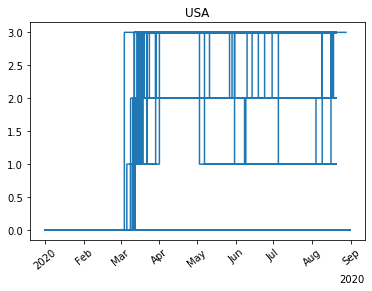

In [31]:
foo = [(dd['Date'],dd['C1_School closing'],dd['C1_Flag']) 
       for dd in oxdat if dd['CountryCode']=='USA']

fmt = '%Y%m%d'
first = 31+22-1
xx = [datetime.datetime.strptime(dd[0],fmt) for dd in foo][first:]
yy = []
for dd in foo[first:]:
    try:
        yy.append(float(dd[1]))
    except:
        yy.append(float('NaN'))


locator = mdates.MonthLocator()
formatter= mdates.ConciseDateFormatter(locator)

fig,ax = plt.subplots(1,1)
ax.step(xx,yy)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
for tick in ax.get_xticklabels():
    tick.set_rotation(40)
plt.title('USA')
plt.show()

Note:  no wildcard data:

In [32]:
foo = [(dd['Date'],dd['CountryCode'],dd['M1_Wildcard']) 
       for dd in oxdat if dd['M1_Wildcard'] != '']

In [33]:
foo

[]

Notes:  
* first version of `datcodes` leaves out all flags (general vs. targeted implementation)
* 2nd version leaves out all variables measured in dollars

In [34]:
datcodes = ['C1_School closing', 'C2_Workplace closing', 
            'C3_Cancel public events', 'C4_Restrictions on gatherings', 
            'C5_Close public transport', 'C6_Stay at home requirements', 
            'C7_Restrictions on internal movement', 'C8_International travel controls', 
            'E1_Income support', 'E2_Debt/contract relief', 'E3_Fiscal measures', 
            'E4_International support', 'H1_Public information campaigns', 
            'H2_Testing policy', 'H3_Contact tracing', 
            'H4_Emergency investment in healthcare', 'H5_Investment in vaccines']

datcodes = ['C1_School closing', 'C2_Workplace closing', 
            'C3_Cancel public events', 'C4_Restrictions on gatherings', 
            'C5_Close public transport', 'C6_Stay at home requirements', 
            'C7_Restrictions on internal movement', 'C8_International travel controls', 
            'E1_Income support', 'E2_Debt/contract relief', 
            'H1_Public information campaigns', 
            'H2_Testing policy', 'H3_Contact tracing']



In [35]:
countrycodes = list(set([dd['CountryCode'] for dd in oxdat if Float(dd['ConfirmedCases'])>10000]))
len(countrycodes)

90

In [36]:
countriesox = list(set([dd['CountryName'] for dd in oxdat if Float(dd['ConfirmedCases'])>10000]))

In [37]:
len(countriesox)

90

In [38]:
def Float(x):
    try:
        rtn = float(x)
    except:
        rtn = float('NaN')
    return rtn


In [39]:
datcodes

['C1_School closing',
 'C2_Workplace closing',
 'C3_Cancel public events',
 'C4_Restrictions on gatherings',
 'C5_Close public transport',
 'C6_Stay at home requirements',
 'C7_Restrictions on internal movement',
 'C8_International travel controls',
 'E1_Income support',
 'E2_Debt/contract relief',
 'H1_Public information campaigns',
 'H2_Testing policy',
 'H3_Contact tracing']

In [40]:
def get_codedat(countrycode='USA'):
    codedat = []
    foo = [[dd['Date']]+ [Float(dd[c]) for c in datcodes]
           for dd in oxdat if dd['CountryCode']==countrycode]
    return foo
    


In [41]:
get_codedat()

[['20200101', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200102', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200103', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200104', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200105', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200106', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200107', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200108', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200109', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200110', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200111', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200112', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['20200113', 0.0, 0.0, 0.0, 0.0, 0.0, 0

### Stringency

In [42]:
[x for x in oxdat[0]]

['CountryName',
 'CountryCode',
 'RegionName',
 'RegionCode',
 'Date',
 'C1_School closing',
 'C1_Flag',
 'C2_Workplace closing',
 'C2_Flag',
 'C3_Cancel public events',
 'C3_Flag',
 'C4_Restrictions on gatherings',
 'C4_Flag',
 'C5_Close public transport',
 'C5_Flag',
 'C6_Stay at home requirements',
 'C6_Flag',
 'C7_Restrictions on internal movement',
 'C7_Flag',
 'C8_International travel controls',
 'E1_Income support',
 'E1_Flag',
 'E2_Debt/contract relief',
 'E3_Fiscal measures',
 'E4_International support',
 'H1_Public information campaigns',
 'H1_Flag',
 'H2_Testing policy',
 'H3_Contact tracing',
 'H4_Emergency investment in healthcare',
 'H5_Investment in vaccines',
 'M1_Wildcard',
 'ConfirmedCases',
 'ConfirmedDeaths',
 'StringencyIndex',
 'StringencyIndexForDisplay',
 'StringencyLegacyIndex',
 'StringencyLegacyIndexForDisplay',
 'GovernmentResponseIndex',
 'GovernmentResponseIndexForDisplay',
 'ContainmentHealthIndex',
 'ContainmentHealthIndexForDisplay',
 'EconomicSupportIn

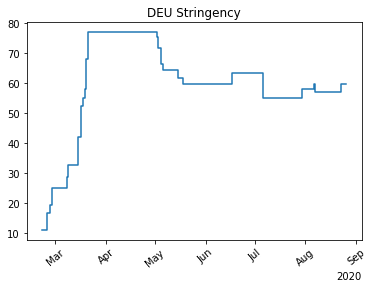

In [43]:
country='DEU'
reg = '' # to get entire country for UK, USA
foo = [(dd['Date'],dd['StringencyIndex'],dd['C1_Flag']) 
       for dd in oxdat if dd['CountryCode']==country and dd['RegionName']==reg]

fmt = '%Y%m%d'
first = 31+22-1  # to get to Feb 22 where data starts
xx = [datetime.datetime.strptime(dd[0],fmt) for dd in foo][first:]
yy = []
for dd in foo[first:]:
    try:
        yy.append(float(dd[1]))
    except:
        yy.append(float('NaN'))


locator = mdates.MonthLocator()
formatter= mdates.ConciseDateFormatter(locator)

fig,ax = plt.subplots(1,1)
ax.step(xx,yy)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
for tick in ax.get_xticklabels():
    tick.set_rotation(40)
plt.title(country+' Stringency')
plt.show()

In [44]:
print("number of countries",len(countrycodes))

number of countries 90


In [45]:
def get_stringency(country):
    yy=[]
    foo = [(dd['Date'],dd['StringencyIndex'],dd['C1_Flag']) 
       for dd in oxdat if dd['CountryName']==country and dd['RegionName']=='']
    fmt = '%Y%m%d'
    first = 31+22-1  # to get to Feb 22 where data starts
    dates = [datetime.datetime.strptime(dd[0],fmt) for dd in foo][first:]
    for dd in foo[first:]:
        try:
            yy.append(float(dd[1]))
        except:
            yy.append(float('NaN'))
    return([dates,yy])
    

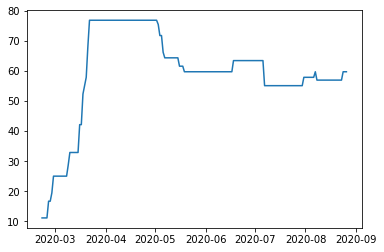

In [46]:
foo = get_stringency('Germany')
plt.plot(foo[0],foo[1]);

In [47]:
import matplotlib.dates as mdates


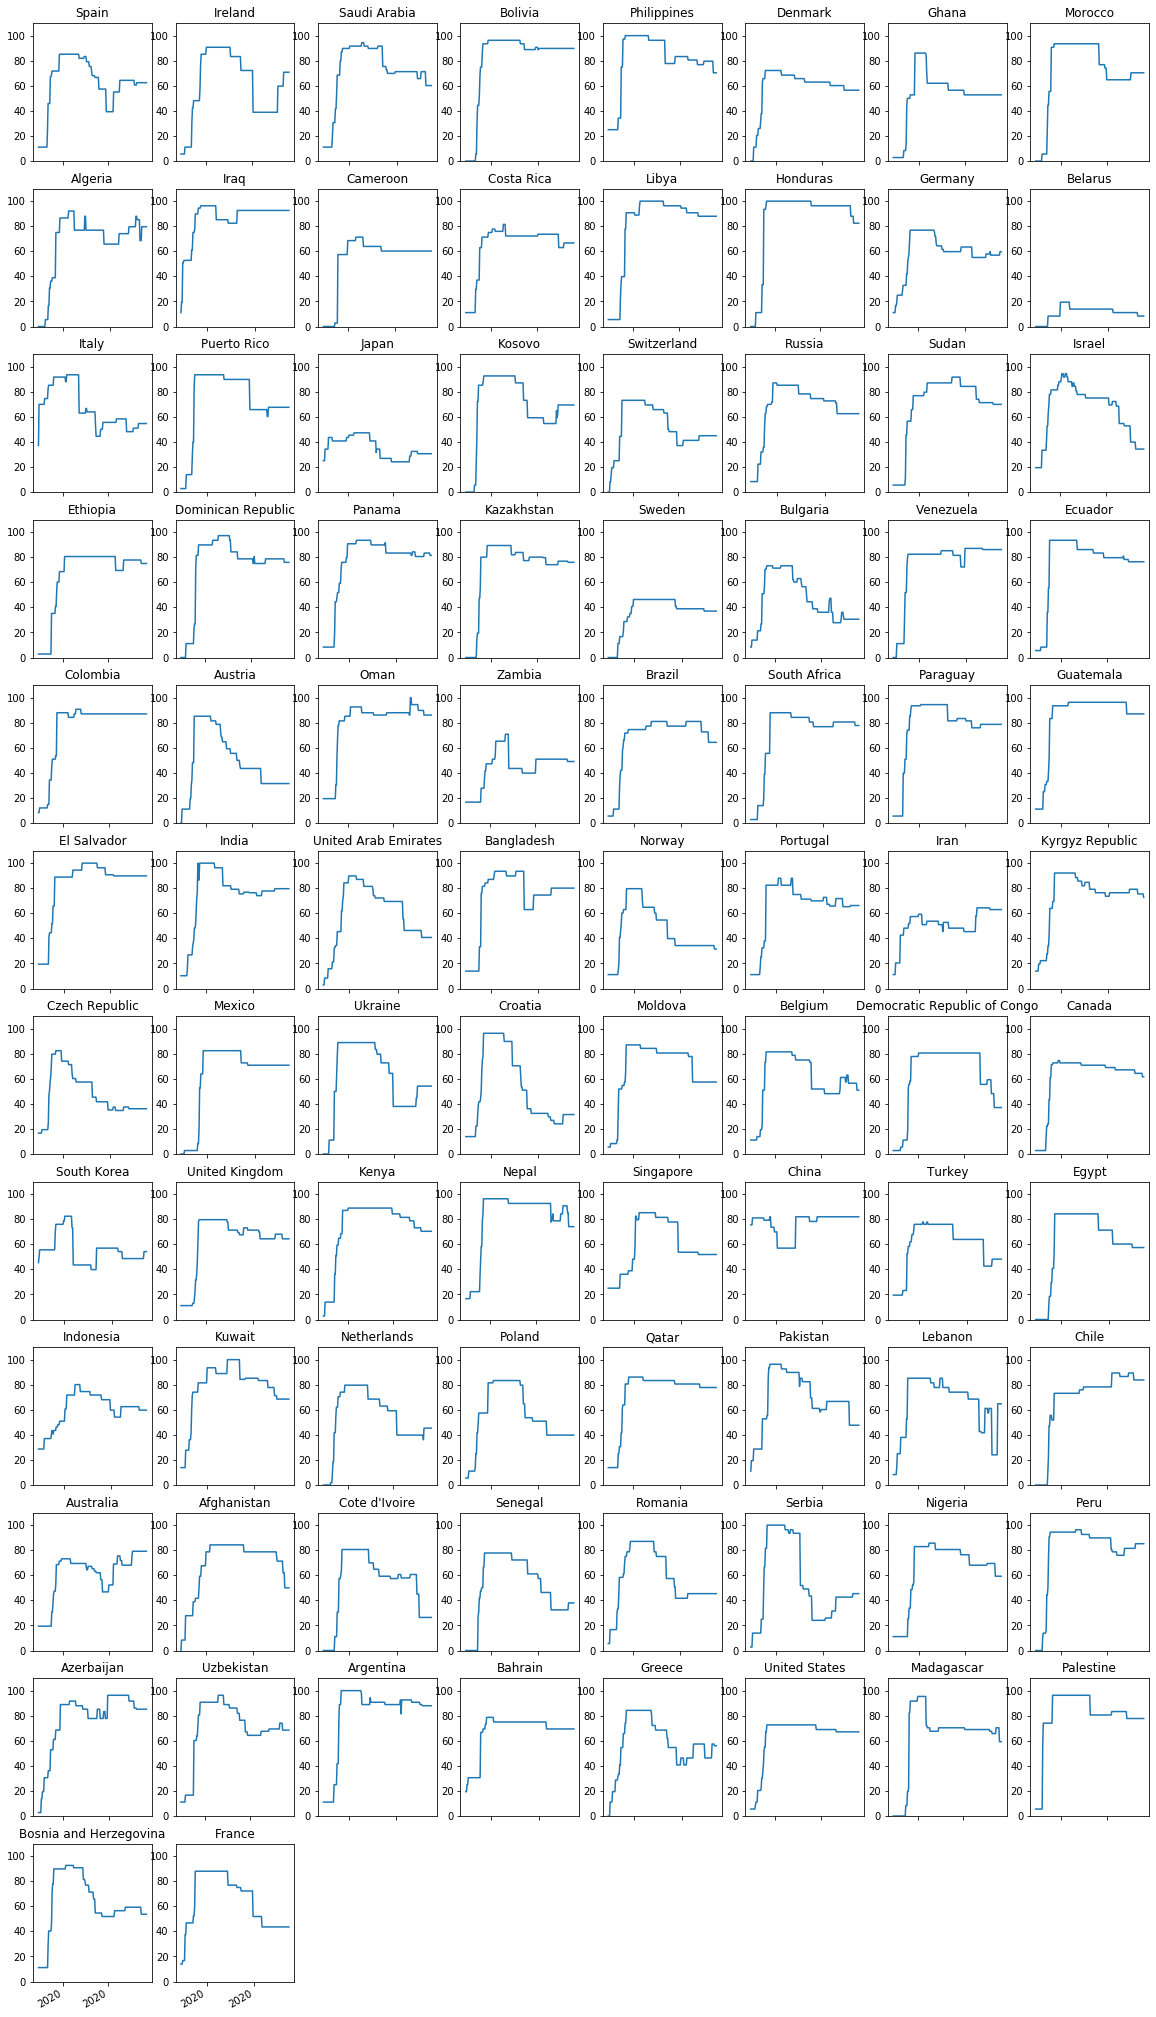

In [48]:
max_rows=12
max_cols=8
idx = 0
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(20,40))
fig.autofmt_xdate()
for idx, country  in enumerate(countriesox):
    foo = get_stringency(country)
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].set_ylim((0,110))
    axes[row, col].xaxis.set_major_locator(plt.MaxNLocator(3))
    axes[row, col].fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    axes[row, col].plot(foo[0],foo[1])
    axes[row, col].set_title(country)
for idx in range(len(countriesox),max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")

In [49]:
len(countriesox)

90

In [60]:
import pickle as pk

In [92]:
dicstringency={}
for cc in countriesox:
    foo = get_stringency(cc)
    dicstringency[cc] = [x[1] for x in foo] # skip date
dates = [x[0] for x in foo]
stringency={}
stringency['dates'] = dates
stringency['data'] = dicstringency
pk.dump(stringency,open('stringency.pk','wb'))

# Parameter fitting

## Fitting via sliders

### SC3EIR Model

In [144]:
len(t)

224

In [145]:
model = 'SC3EIR'
params={'beta':0.25,'alpha':1./5.,'gamma':0.1,'mu':0.05,'c_0':0.3, 'c_1':1/14., 'c_2':2000}
def slidefitplot(beta,alpha,gamma,mu,c_0,c_1,c_2,logI_0):
    params={ 'beta':beta, 'alpha':alpha, 'gamma':gamma, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2}
    cmodels[model].parameters = params
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.]
    cmodels[model].initial_values = (x0,t[0])
    solveplot(smodels=[model],species=['confirmed','recovered','deaths'],tmax=len(t),summing='daily',fitdata=y_jhu[test_country],scale='linear',plottitle= '',label='confirmed',newplot = True)

fit data  (224, 3)


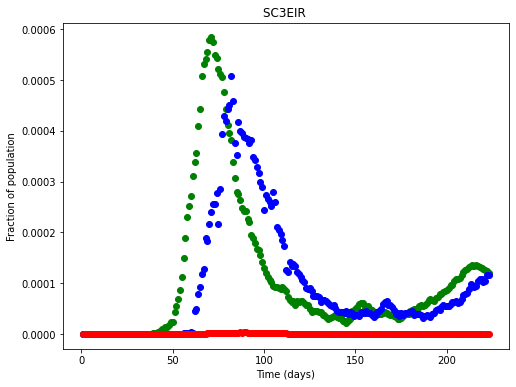

<function __main__.slidefitplot(beta, alpha, gamma, mu, c_0, c_1, c_2, logI_0)>

In [146]:
interact(slidefitplot,
         beta=FloatSlider(min=0,max=1,step=0.01,value=params['beta'],description='beta',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         alpha=FloatSlider(min=0,max=1,step=0.01,value=params['alpha'],description='alpha',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         gamma=FloatSlider(min=0,max=1,step=0.01,value=params['gamma'],description='gamma',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=5000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False))

### SC3EI3R Model

#### Germany

In [196]:
# assumed data starting on firstdate
test_country='Germany'
N = 80000000
firstdate = '01/25/20'
lastdate = '01/08/20'
xx,xxf,yy0 = get_country_data(test_country,'confirmed',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy1 = get_country_data(test_country,'recovered',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy2 = get_country_data(test_country,'deaths',firstdate=firstdate,lastdate=lastdate)
print(xxf)
y_jhu={}
y_jhu[test_country] = np.array([[yy0[i],yy1[i],yy2[i]] for i in range(0,len(yy0))])/N
# data = np.array([[xxf[i],yy0[i],yy1[i],yy2[i]] for i in range(len(yy))])
# print(data)
lastday = len(y_jhu[test_country])
print('days 0 to',lastday,'data stored in y_jhu')

[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0,

In [197]:
len(t)

224

In [198]:
(1.0/TimeICUDeath)*(CFR/FracCritical)

0.16666666666666669

In [202]:
model = 'SC3EI3R'

# Define parameters based on clinical observations Dr. Alison
Exposure=0.4 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=10 #Duration of mild infections, days  : includes time for reg. of recovery
FracMild=0.7  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.1 #Fraction of infections that are critical
CFR=0.05 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=5 #Time from ICU admission to death, days
DurHosp=4 #Duration of hospitalization, days  : includes 4 day reg of recovery

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=1.0  # Fraction of recovered individuals measured : plots made with this parameter NYI
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.1 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.1 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.001 # Fraction of ICUs relative to population size N

params = {'beta_1' : Exposure/sum(x0_SC3EI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0_SC3EI3R)*ICUFrac*CautionICUFrac),
          'N'     : sum(x0_SC3EI3R)}

print(params)
SC3EI3R_model.parameters = params

def slidefitplot(beta_1,mu,c_0,c_1,c_2,logI_0):
    params={ 'beta_1':beta_1, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2}
    cmodels[model].parameters = params
    
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.]

    cmodels[model].initial_values = (x0,t[0])
    weights=np.array([1.,1.,1.])
    solveplot(smodels=[model],species=['confirmed','recovered','deaths_x10'],tmax=len(t),summing='daily',averaging='weekly',fitdata=y_jhu[test_country]*weights,scale='linear',plottitle= '',label='confirmed',newplot = True, figsize = (15,15))

{'beta_1': 0.4, 'beta_2': 0.0, 'beta_3': 0.0, 'alpha': 0.2, 'gamma_1': 0.06999999999999999, 'gamma_2': 0.16666666666666669, 'gamma_3': 0.1, 'p_1': 0.030000000000000013, 'p_2': 0.08333333333333333, 'mu': 0.1, 'c_0': 0.1, 'c_1': 0.016666666666666666, 'c_2': 10000.0, 'N': 1.0}


fit data  (224, 3)


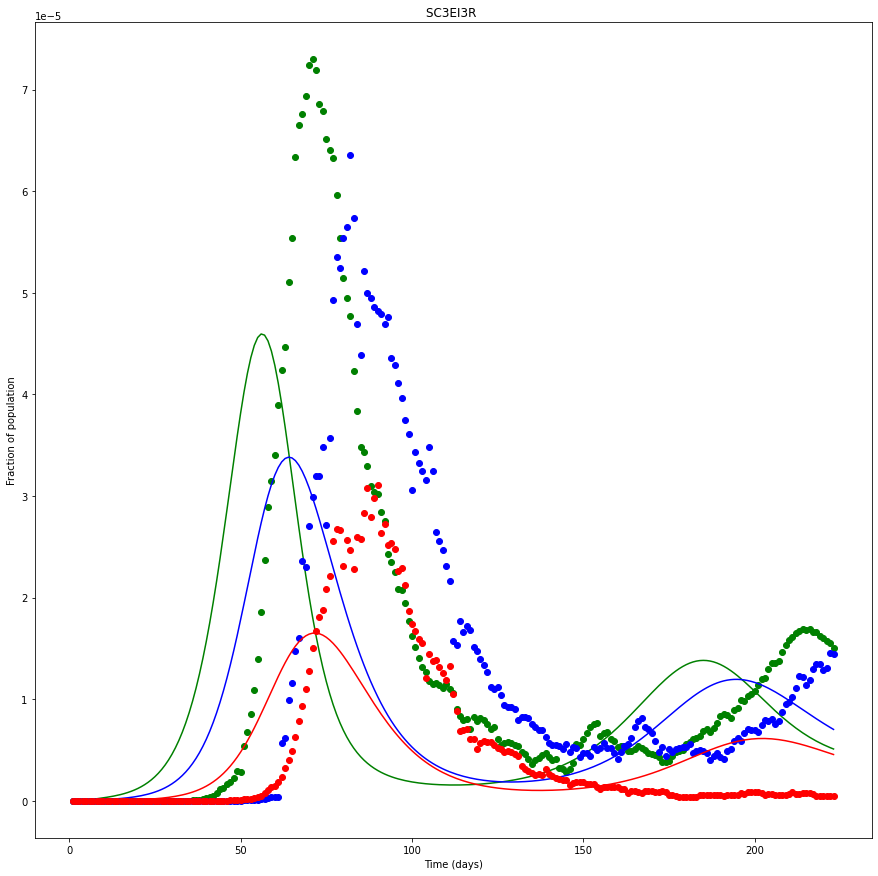

In [203]:
w =interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=20000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False)
         )
display(w)

In [152]:
params=w.kwargs

print(params)

{'beta_1': 0.4, 'mu': 0.1, 'c_0': 0.1, 'c_1': 0.016666666666666666, 'c_2': 10000.0, 'logI_0': -6.0}


#### Spain

In [153]:
# assumed data starting on firstdate
test_country='Spain'
N = 80000000
firstdate = '01/25/20'
lastdate = '01/08/20'
xx,xxf,yy0 = get_country_data(test_country,'confirmed',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy1 = get_country_data(test_country,'recovered',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy2 = get_country_data(test_country,'deaths',firstdate=firstdate,lastdate=lastdate)
print(xxf)
y_jhu={}
y_jhu[test_country] = np.array([[yy0[i],yy1[i],yy2[i]] for i in range(0,len(yy0))])/N
# data = np.array([[xxf[i],yy0[i],yy1[i],yy2[i]] for i in range(len(yy))])
# print(data)
lastday = len(y_jhu[test_country])
print('days 0 to',lastday,'data stored in y_jhu')

[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0,

In [154]:
len(t)

224

In [155]:
(1.0/TimeICUDeath)*(CFR/FracCritical)

0.1

In [156]:
model = 'SC3EI3R'

# Define parameters based on clinical observations Dr. Alison
Exposure=0.4 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=10 #Duration of mild infections, days  : includes time for reg. of recovery
FracMild=0.7  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.1 #Fraction of infections that are critical
CFR=0.05 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=5 #Time from ICU admission to death, days
DurHosp=4 #Duration of hospitalization, days  : includes 4 day reg of recovery

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.5  # Fraction of confirmed individuals measured : plots made with this parameter NYI
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.1 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.1 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.001 # Fraction of ICUs relative to population size N

params = {'beta_1' : Exposure/sum(x0_SC3EI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0_SC3EI3R)*ICUFrac*CautionICUFrac),
          'N'     : sum(x0_SC3EI3R)}

print(params)
SC3EI3R_model.parameters = params

def slidefitplot(beta_1,mu,c_0,c_1,c_2,logI_0):
    params={ 'beta_1':beta_1, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2}
    cmodels[model].parameters = params
    
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.]

    cmodels[model].initial_values = (x0,t[0])
    weights=np.array([1.,1.,1.])
    solveplot(smodels=[model],species=['confirmed','recovered','deaths_x10'],tmax=len(t),summing='daily',averaging='weekly',fitdata=y_jhu[test_country]*weights,scale='linear',plottitle= '',label='confirmed',newplot = True, figsize = (15,15))

{'beta_1': 0.4, 'beta_2': 0.0, 'beta_3': 0.0, 'alpha': 0.2, 'gamma_1': 0.06999999999999999, 'gamma_2': 0.16666666666666669, 'gamma_3': 0.1, 'p_1': 0.030000000000000013, 'p_2': 0.08333333333333333, 'mu': 0.1, 'c_0': 0.1, 'c_1': 0.016666666666666666, 'c_2': 10000.0, 'N': 1.0}


fit data  (224, 3)


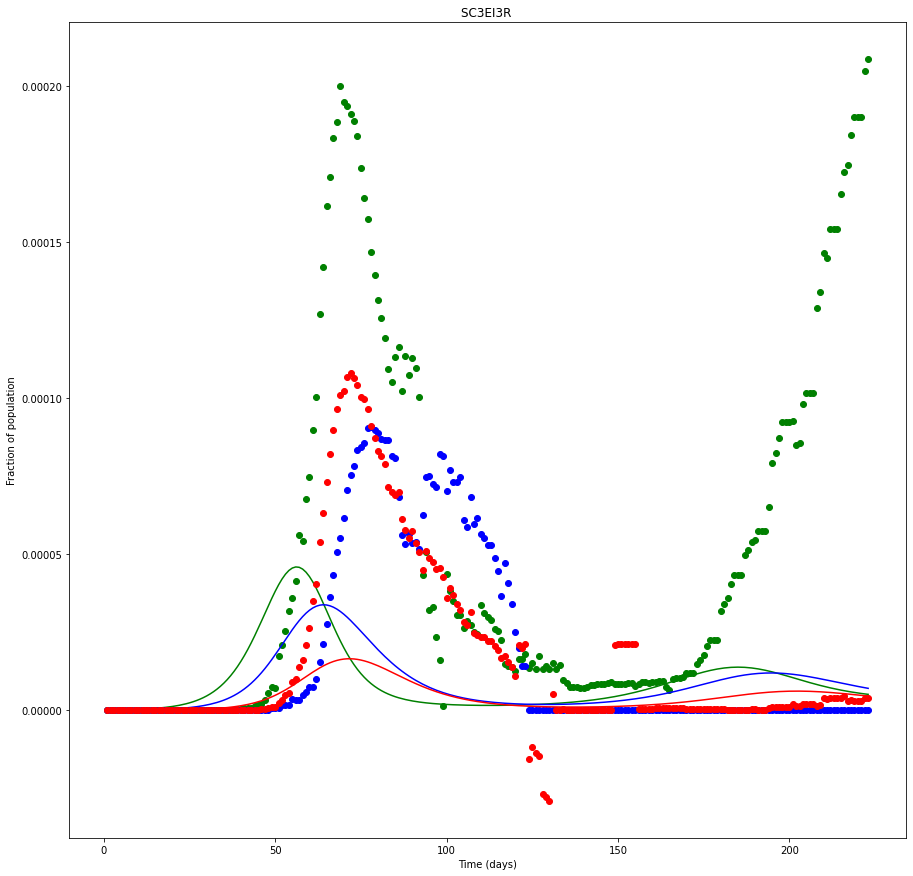

In [157]:
w =interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=20000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False)
         )
display(w)

In [158]:
params=w.kwargs

print(params)

{'beta_1': 0.4, 'mu': 0.1, 'c_0': 0.1, 'c_1': 0.016666666666666666, 'c_2': 10000.0, 'logI_0': -6.0}


#### Italy

In [159]:
# assumed data starting on firstdate
test_country='Italy'
N = 66650000
firstdate = '01/25/20'
lastdate = '01/08/20'
xx,xxf,yy0 = get_country_data(test_country,'confirmed',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy1 = get_country_data(test_country,'recovered',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy2 = get_country_data(test_country,'deaths',firstdate=firstdate,lastdate=lastdate)
print(xxf)
y_jhu={}
y_jhu[test_country] = np.array([[yy0[i],yy1[i],yy2[i]] for i in range(0,len(yy0))])/N
# data = np.array([[xxf[i],yy0[i],yy1[i],yy2[i]] for i in range(len(yy))])
# print(data)
lastday = len(y_jhu[test_country])
print('days 0 to',lastday,'data stored in y_jhu')

[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0,

In [160]:
model = 'SC3EI3R'

# Define parameters based on clinical observations Dr. Alison
Exposure=0.4 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=8 #Duration of mild infections, days
FracMild=0.65  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.15 #Fraction of infections that are critical
CFR=0.1 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=4 #Time from ICU admission to death, days
DurHosp=4 #Duration of hospitalization, days

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.5  # Fraction of infected individuals confirmed
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.1 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.1 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.001 # Fraction of ICUs relative to population size N

params = {'beta_1' : Exposure/sum(x0_SC3EI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0_SC3EI3R)*ICUFrac*CautionICUFrac),
          'N'     : sum(x0_SC3EI3R)}

print(params)
SC3EI3R_model.parameters = params

def slidefitplot(beta_1,mu,c_0,c_1,c_2,logI_0):
    params={ 'beta_1':beta_1, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2}
    cmodels[model].parameters = params
    
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.]

    cmodels[model].initial_values = (x0,t[0])
    weights=np.array([1.,1.,1.])
    solveplot(smodels=[model],species=['confirmed','recovered','deaths_x10'],tmax=len(t),summing='daily',averaging='weekly',fitdata=y_jhu[test_country]*weights,scale='linear',plottitle= '',label='confirmed',newplot = True, figsize = (15,15))

{'beta_1': 0.4, 'beta_2': 0.0, 'beta_3': 0.0, 'alpha': 0.2, 'gamma_1': 0.08125, 'gamma_2': 0.14285714285714285, 'gamma_3': 0.08333333333333331, 'p_1': 0.04375, 'p_2': 0.10714285714285715, 'mu': 0.16666666666666669, 'c_0': 0.1, 'c_1': 0.016666666666666666, 'c_2': 10000.0, 'N': 1.0}


fit data  (224, 3)


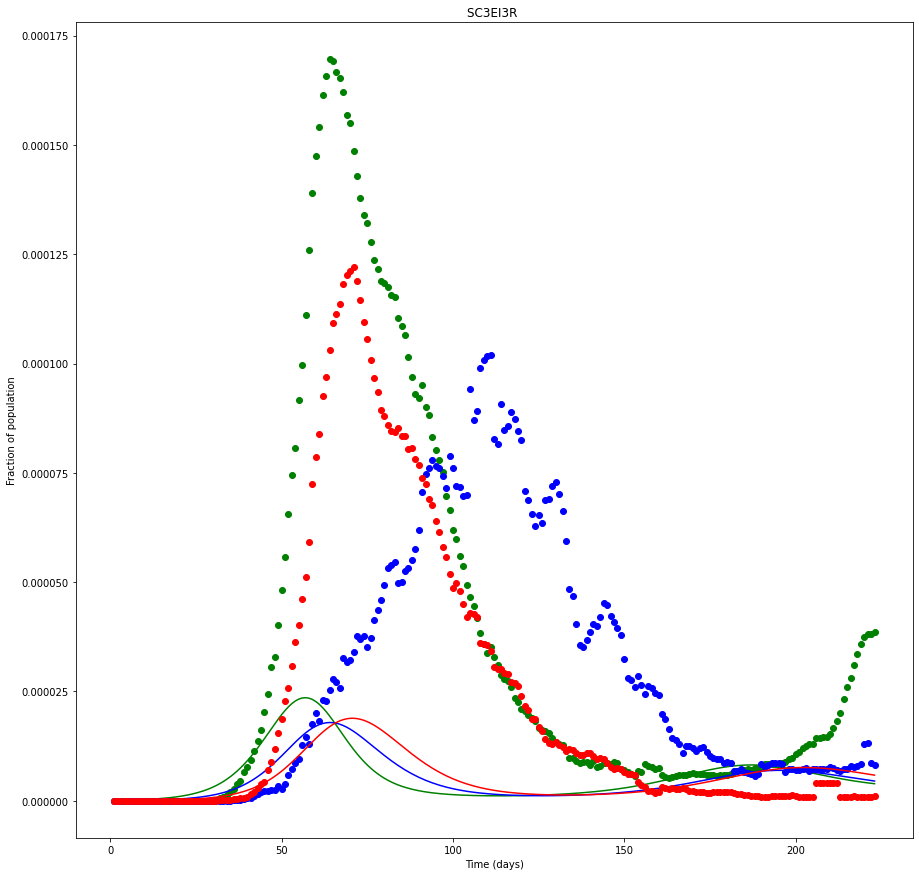

In [161]:
w =interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=20000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False)
         )
display(w)

In [162]:
params=w.kwargs

print(params)

{'beta_1': 0.4, 'mu': 0.16666666666666669, 'c_0': 0.1, 'c_1': 0.016666666666666666, 'c_2': 10000.0, 'logI_0': -6.0}


Note that we have used 50% detection of confirmed and recovered, 100% for deaths in manual fit. 
It appears that Italy's registration of recovery, although the right overall magnitude is markedly delayed - check reporting delays.
Italy also had at least two successive regional infections, as seen in the dual peak confirmed data, so not easy to fit with one model.
See below for simulation of second peak.

fit data  (224, 3)


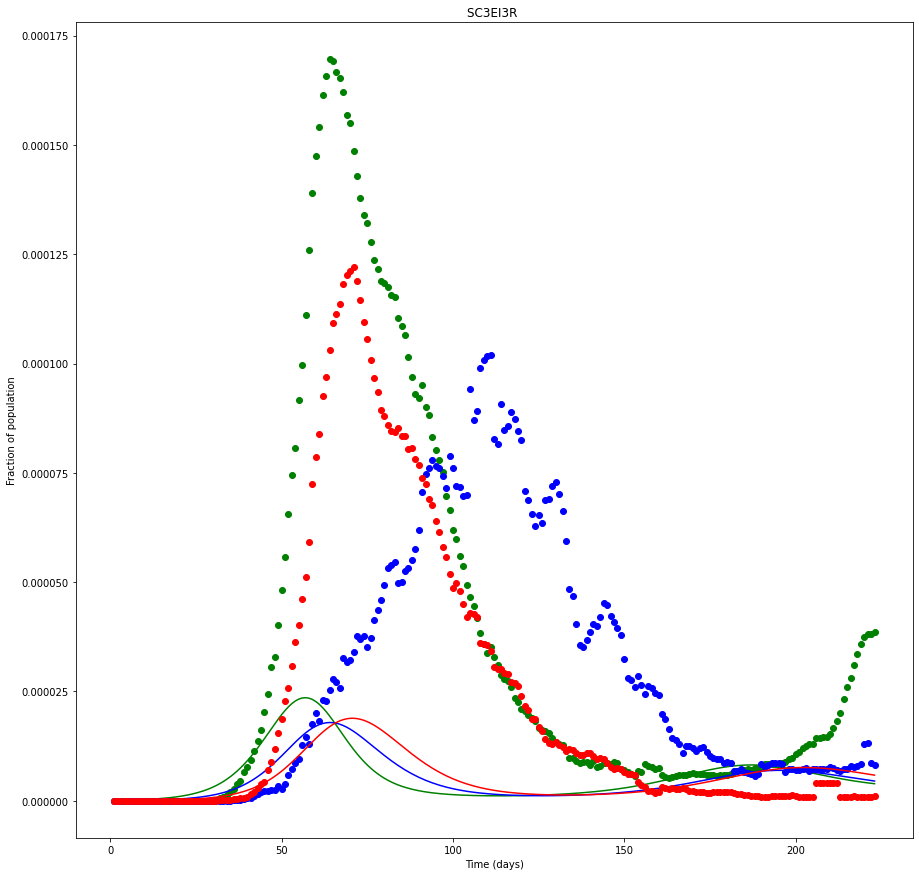

In [163]:
w =interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=20000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False)
         )
display(w)

#### Brazil

In [164]:
# assumed data starting on firstdate
test_country='Brazil'
N = 210000000
firstdate = '01/25/20'
lastdate = '01/08/20'
xx,xxf,yy0 = get_country_data(test_country,'confirmed',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy1 = get_country_data(test_country,'recovered',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy2 = get_country_data(test_country,'deaths',firstdate=firstdate,lastdate=lastdate)
print(xxf)
y_jhu={}
y_jhu[test_country] = np.array([[yy0[i],yy1[i],yy2[i]] for i in range(0,len(yy0))])/N
# data = np.array([[xxf[i],yy0[i],yy1[i],yy2[i]] for i in range(len(yy))])
# print(data)
lastday = len(y_jhu[test_country])
print('days 0 to',lastday,'data stored in y_jhu')

[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0,

In [165]:
model = 'SC3EI3R'

# Define parameters based on clinical observations Dr. Alison
Exposure=0.4 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=8 #Duration of mild infections, days
FracMild=0.65  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.15 #Fraction of infections that are critical
CFR=0.1 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=4 #Time from ICU admission to death, days
DurHosp=8 #Duration of hospitalization, days

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.1 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.1 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.001 # Fraction of ICUs relative to population size N

params = {'beta_1' : Exposure/sum(x0_SC3EI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0_SC3EI3R)*ICUFrac*CautionICUFrac),
          'N'     : sum(x0_SC3EI3R)}

print(params)
SC3EI3R_model.parameters = params

def slidefitplot(beta_1,mu,c_0,c_1,c_2,logI_0):
    params={ 'beta_1':beta_1, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2}
    cmodels[model].parameters = params
    
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.]

    cmodels[model].initial_values = (x0,t[0])
    weights=np.array([1.,1.,1.])
    solveplot(smodels=[model],species=['confirmed','recovered','deaths_x10'],tmax=len(t),summing='cumulative',averaging='weekly',fitdata=y_jhu[test_country]*weights,scale='linear',plottitle= '',label='confirmed',newplot = True, figsize = (15,15))

{'beta_1': 0.4, 'beta_2': 0.0, 'beta_3': 0.0, 'alpha': 0.2, 'gamma_1': 0.08125, 'gamma_2': 0.07142857142857142, 'gamma_3': 0.08333333333333331, 'p_1': 0.04375, 'p_2': 0.053571428571428575, 'mu': 0.16666666666666669, 'c_0': 0.1, 'c_1': 0.016666666666666666, 'c_2': 10000.0, 'N': 1.0}


fit data  (224, 3)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:111: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in true_divide


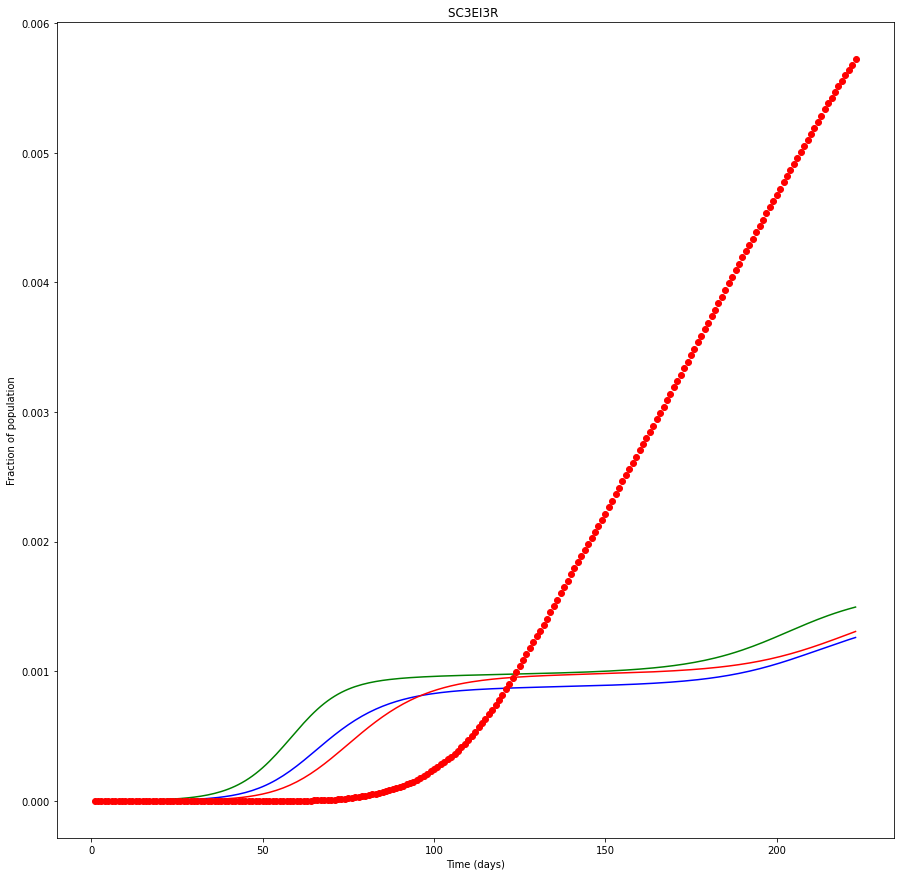

In [166]:
w =interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=20000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False)
         )
display(w)

The Brazil data shows that death is not as delayed as assumed. The process of progression is perhaps less clearly documented.

#### Russia

In [167]:
# assumed data starting on firstdate
test_country='Iran'
N = 144500000
firstdate = '01/25/20'
lastdate = '01/08/20'
xx,xxf,yy0 = get_country_data(test_country,'confirmed',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy1 = get_country_data(test_country,'recovered',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy2 = get_country_data(test_country,'deaths',firstdate=firstdate,lastdate=lastdate)
print(xxf)
y_jhu={}
y_jhu[test_country] = np.array([[yy0[i],yy1[i],yy2[i]] for i in range(0,len(yy0))])/N
# data = np.array([[xxf[i],yy0[i],yy1[i],yy2[i]] for i in range(len(yy))])
# print(data)
lastday = len(y_jhu[test_country])
print('days 0 to',lastday,'data stored in y_jhu')

[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0,

In [168]:
model = 'SC3EI3R'

# Define parameters based on clinical observations Dr. Alison
Exposure=0.4 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=8 #Duration of mild infections, days
FracMild=0.65  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.15 #Fraction of infections that are critical
CFR=0.1 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=4 #Time from ICU admission to death, days
DurHosp=8 #Duration of hospitalization, days

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.1 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.1 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.002 # Fraction of ICUs relative to population size N

params = {'beta_1' : Exposure/sum(x0_SC3EI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0_SC3EI3R)*ICUFrac*CautionICUFrac),
          'N'     : sum(x0_SC3EI3R)}

print(params)
SC3EI3R_model.parameters = params

def slidefitplot(beta_1,mu,c_0,c_1,c_2,logI_0):
    params={ 'beta_1':beta_1, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2}
    cmodels[model].parameters = params
    
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.]

    cmodels[model].initial_values = (x0,t[0])
    weights=np.array([1.,1.,1.])
    solveplot(smodels=[model],species=['confirmed','recovered','deaths_x10'],tmax=len(t),summing='cumulative',averaging='weekly',fitdata=y_jhu[test_country]*weights,scale='linear',plottitle= '',label='confirmed',newplot = True, figsize = (15,15))

{'beta_1': 0.4, 'beta_2': 0.0, 'beta_3': 0.0, 'alpha': 0.2, 'gamma_1': 0.08125, 'gamma_2': 0.07142857142857142, 'gamma_3': 0.08333333333333331, 'p_1': 0.04375, 'p_2': 0.053571428571428575, 'mu': 0.16666666666666669, 'c_0': 0.1, 'c_1': 0.016666666666666666, 'c_2': 5000.0, 'N': 1.0}


fit data  (224, 3)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:111: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in true_divide


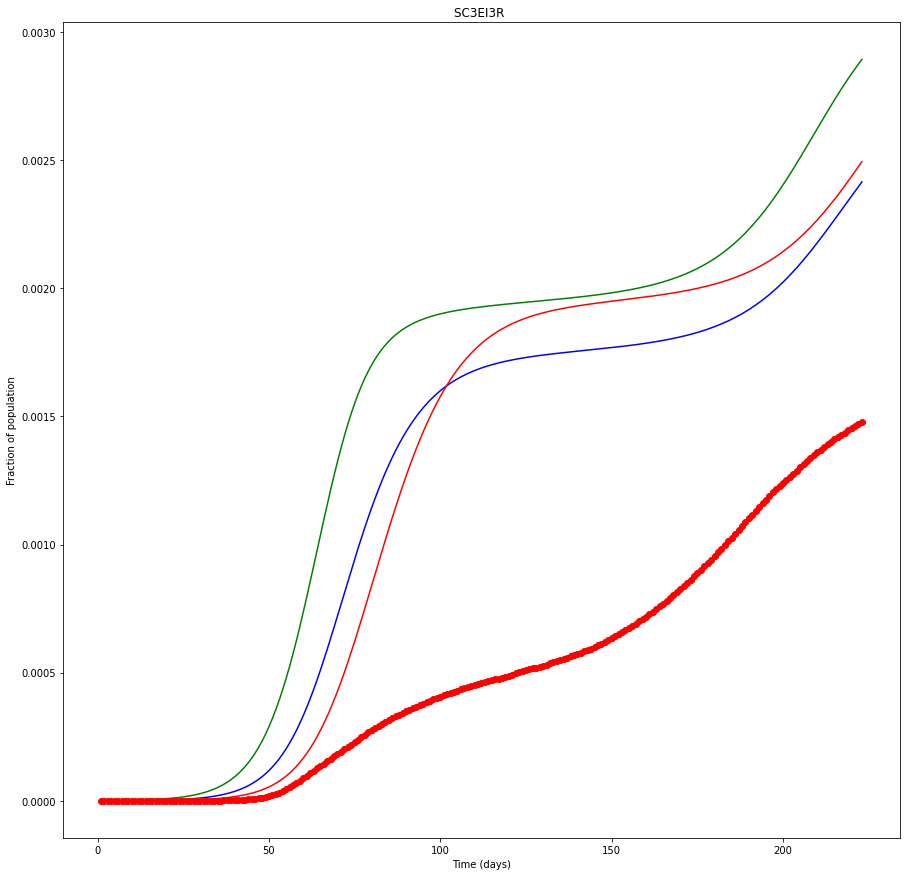

In [169]:
w =interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=20000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False)
         )
display(w)

### SC3UEIR Model

In [170]:
# assumed data starting on firstdate
test_country='US'
N = 66650000
firstdate = '01/25/20'
lastdate = '01/08/20'
xx,xxf,yy0 = get_country_data(test_country,'confirmed',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy1 = get_country_data(test_country,'recovered',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy2 = get_country_data(test_country,'deaths',firstdate=firstdate,lastdate=lastdate)
print(xxf)
y_jhu={}
y_jhu[test_country] = np.array([[yy0[i],yy1[i],yy2[i]] for i in range(0,len(yy0))])/N
# data = np.array([[xxf[i],yy0[i],yy1[i],yy2[i]] for i in range(len(yy))])
# print(data)
lastday = len(y_jhu[test_country])
print('days 0 to',lastday,'data stored in y_jhu')

[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0,

In [171]:
model = 'SC3UEIR'
I_0 =  0.00003
x0_SC3UEIR = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
SC3UEIR_model.initial_values = (x0_SC3UEIR, t[0])

# Define parameters based on clinical observations Dr. Alison
Exposure=0.4 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=8 #Duration of mild infections, days
FracMild=0.65  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.15 #Fraction of infections that are critical
CFR=0.1 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=4 #Time from ICU admission to death, days
DurHosp=8 #Duration of hospitalization, days

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.5  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.1 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.1 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.001 # Fraction of ICUs relative to population size N

# Model extension by John McCaskill to include economic influence on caution 
EconomicCostOfCaution= 0.5 # Fractional reduction of economic contribution for cautioned individuals

p = [0,(1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,  (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere))]
g = [0,(1.0/DurMildInf)*FracMild,   (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
           (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical)]
u = (1.0/TimeICUDeath)*(CFR/FracCritical)
                
params = {'beta' : Exposure/sum(x0_SC3UEIR),
          'alpha' : 1.0/IncubPeriod,
          'gamma' :  g[1]+g[2]*(p[1]/(g[2]+p[2]))+g[3]*(p[1]/(g[2]+p[2]))*(p[2]/(g[3]+u)),
          'mu'     : u*(p[1]/(g[2]+p[2])*(p[2]/(g[3]+u))),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(sum(x0_SC3UEIR)*ICUFrac*CautionICUFrac),
          'N'      : sum(x0_SC3UEIR),
          'k_u'    : 1.0/CautionRetention,
          'k_1'    : 1.0/CautionRetention,
          'k_w'    : 1.0/CautionRetention,
          'kappa'  : EconomicCostOfCaution}

print(params)
SC3UEIR_model.parameters = params.copy()
# solution = SCIR_model.integrate(t[1::])

def slidefitplot(beta,alpha,gamma,mu,c_0,c_1,c_2,logI_0,k_u,k_1,k_w,kappa):
    params={ 'beta':beta, 'alpha':alpha, 'gamma':gamma, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2, 'k_u':k_u, 'k_1':k_1, 'k_w':k_w, 'kappa':kappa}
    cmodels[model].parameters = params
    
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,1.]

    cmodels[model].initial_values = (x0,t[0])
    weights=np.array([1.,1.,1.])
    solveplot(smodels=[model],species=['confirmed','recovered','deaths_x10'],tmax=len(t),summing='daily',averaging='weekly',fitdata=y_jhu[test_country]*weights,scale='linear',plottitle= '',label='confirmed',newplot = True, figsize = (15,15))

{'beta': 0.2, 'alpha': 0.2, 'gamma': 0.11249999999999999, 'mu': 0.0125, 'c_0': 0.1, 'c_1': 0.016666666666666666, 'c_2': 5000.0, 'N': 2.0, 'k_u': 0.016666666666666666, 'k_1': 0.016666666666666666, 'k_w': 0.016666666666666666, 'kappa': 0.5}


fit data  (224, 3)


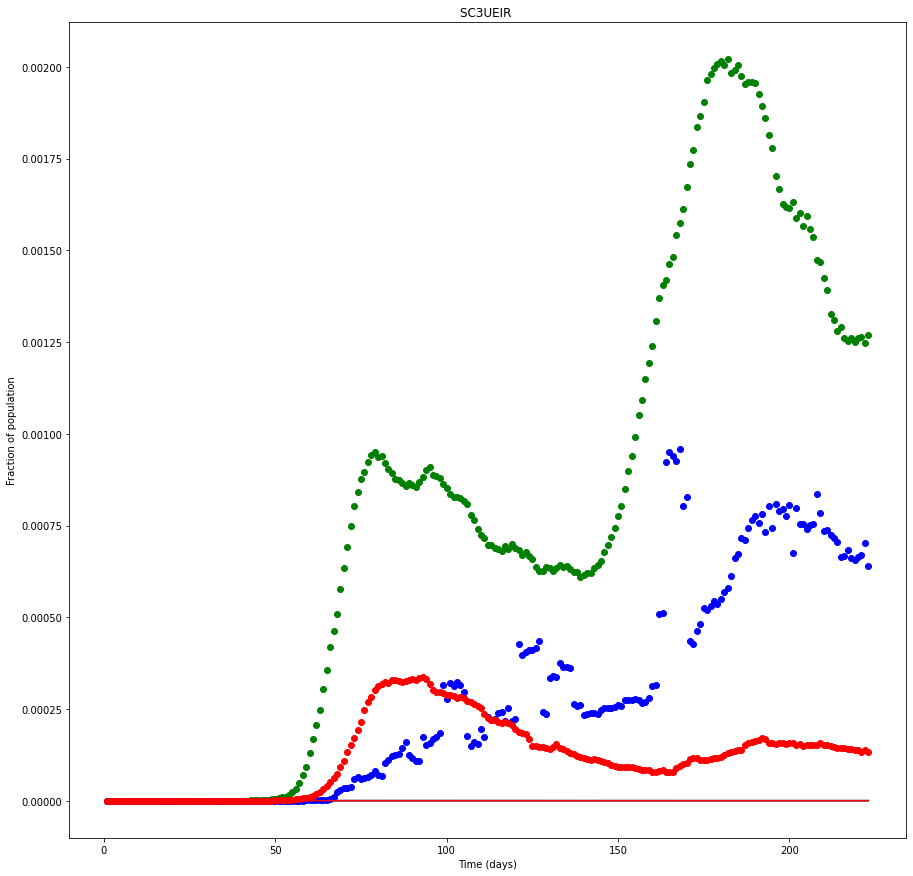

In [172]:
w = interactive(slidefitplot,
         beta=FloatSlider(min=0,max=1,step=0.01,value=params['beta'],description='beta',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         alpha=FloatSlider(min=0,max=1,step=0.01,value=params['alpha'],description='alpha',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         gamma=FloatSlider(min=0,max=1,step=0.01,value=params['gamma'],description='gamma',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=5000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False),
         k_u=FloatSlider(min=0,max=1,step=0.001,value=params['k_u'],description='k_u',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         k_1=FloatSlider(min=0,max=1,step=0.001,value=params['k_1'],description='k_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         k_w=FloatSlider(min=0,max=1,step=0.001,value=params['k_w'],description='k_w',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         kappa=FloatSlider(min=0,max=1,step=0.001,value=params['kappa'],description='kappa',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'))
display(w)

In [173]:
params=w.kwargs
# not a good fit yet, did better last week
print(params)

{'beta': 0.2, 'alpha': 0.2, 'gamma': 0.11249999999999999, 'mu': 0.0125, 'c_0': 0.1, 'c_1': 0.016666666666666666, 'c_2': 5000.0, 'logI_0': -6.0, 'k_u': 0.016666666666666666, 'k_1': 0.016666666666666666, 'k_w': 0.016666666666666666, 'kappa': 0.5}


### SC3UEI3R Model

#### USA

In [174]:
# assumed data starting on firstdate
test_country='US'
N = 66650000
firstdate = '01/25/20'
lastdate = '01/08/20'
xx,xxf,yy0 = get_country_data(test_country,'confirmed',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy1 = get_country_data(test_country,'recovered',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy2 = get_country_data(test_country,'deaths',firstdate=firstdate,lastdate=lastdate)
print(xxf)
y_jhu={}
y_jhu[test_country] = np.array([[yy0[i],yy1[i],yy2[i]] for i in range(0,len(yy0))])/N
# data = np.array([[xxf[i],yy0[i],yy1[i],yy2[i]] for i in range(len(yy))])
# print(data)
lastday = len(y_jhu[test_country])
print('days 0 to',lastday,'data stored in y_jhu')

[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0,

In [175]:
model = 'SC3UEI3R'
I_0 =  0.00003
x0_SC3UEI3R = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
SC3UEI3R_model.initial_values = (x0_SC3UEI3R, t[0])

# Define parameters based on clinical observations Dr. Alison
Exposure=0.4 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=8 #Duration of mild infections, days
FracMild=0.65  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.15 #Fraction of infections that are critical
CFR=0.1 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=4 #Time from ICU admission to death, days
DurHosp=5 #Duration of hospitalization, days

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.5  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.1 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.1 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.001 # Fraction of ICUs relative to population size N

# Model extension by John McCaskill to include economic influence on caution 
EconomicCostOfCaution= 0.5 # Fractional reduction of economic contribution for cautioned individuals

p = [0,(1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,  (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere))]
g = [0,(1.0/DurMildInf)*FracMild,   (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
           (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical)]
u = (1.0/TimeICUDeath)*(CFR/FracCritical)
                
params = {'beta_1' : Exposure/sum(x0_SC3UEI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(ICUFrac*CautionICUFrac),
          'k_u'    : 1.0/5.,
          'k_1'    : 1.0/90,
          'k_w'    : 1.0/90,
          'kappa'  : EconomicCostOfCaution,
          'N'      : sum(x0_SC3UEI3R)}

print(params)
SC3UEI3R_model.parameters = params.copy()

{'beta_1': 0.2, 'beta_2': 0.0, 'beta_3': 0.0, 'alpha': 0.2, 'gamma_1': 0.08125, 'gamma_2': 0.11428571428571428, 'gamma_3': 0.08333333333333331, 'p_1': 0.04375, 'p_2': 0.08571428571428573, 'mu': 0.16666666666666669, 'c_0': 0.1, 'c_1': 0.016666666666666666, 'c_2': 10000.0, 'k_u': 0.2, 'k_1': 0.011111111111111112, 'k_w': 0.011111111111111112, 'kappa': 0.5, 'N': 2.0}


In [176]:
def slidefitplot(beta_1,alpha,mu,c_0,c_1,c_2,logI_0,k_u,k_1,k_w,kappa):
    params={ 'beta_1':beta_1, 'alpha':alpha, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2, 'k_u':k_u, 'k_1':k_1, 'k_w':k_w, 'kappa':kappa}
    cmodels[model].parameters = params
    
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.,0.,1.]

    cmodels[model].initial_values = (x0,t[0])
    weights=np.array([1.,1.,1.])
    solveplot(smodels=[model],species=['confirmed','recovered','deaths_x10'],tmax=len(t),summing='daily',averaging='weekly',fitdata=y_jhu[test_country]*weights,scale='linear',plottitle= '',label='confirmed',newplot = True, figsize = (15,15))

fit data  (224, 3)


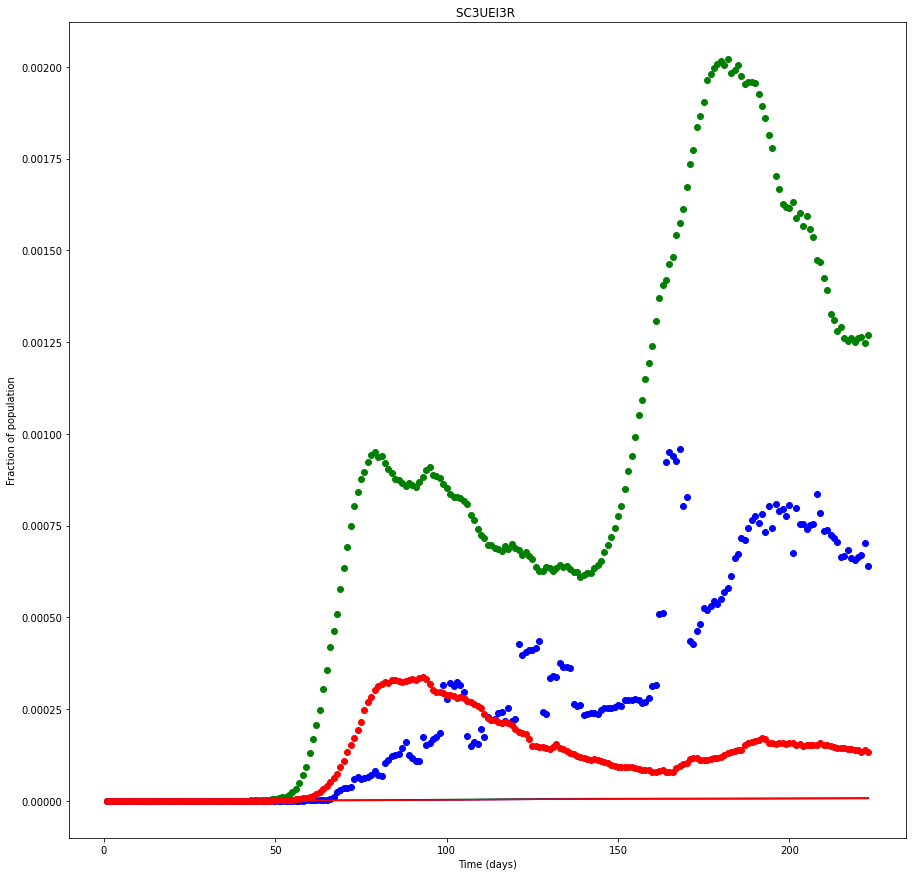

In [177]:
w=interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         alpha=FloatSlider(min=0,max=1,step=0.01,value=params['alpha'],description='alpha',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=5000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False),
         k_u=FloatSlider(min=0,max=1,step=0.001,value=params['k_u'],description='k_u',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         k_1=FloatSlider(min=0,max=1,step=0.001,value=params['k_1'],description='k_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         k_w=FloatSlider(min=0,max=1,step=0.001,value=params['k_w'],description='k_w',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         kappa=FloatSlider(min=0,max=1,step=0.001,value=params['kappa'],description='kappa',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'))
display(w)

In [178]:
params=w.kwargs

print(params)

{'beta_1': 0.2, 'alpha': 0.2, 'mu': 0.16666666666666669, 'c_0': 0.1, 'c_1': 0.016666666666666666, 'c_2': 5000.0, 'logI_0': -6.0, 'k_u': 0.2, 'k_1': 0.011111111111111112, 'k_w': 0.011111111111111112, 'kappa': 0.5}


#### Spain

In [179]:
# assumed data starting on firstdate
test_country='Spain'
N = 66650000
firstdate = '01/25/20'
lastdate = '01/08/20'
xx,xxf,yy0 = get_country_data(test_country,'confirmed',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy1 = get_country_data(test_country,'recovered',firstdate=firstdate,lastdate=lastdate)
xx,xxf,yy2 = get_country_data(test_country,'deaths',firstdate=firstdate,lastdate=lastdate)
print(xxf)
y_jhu={}
y_jhu[test_country] = np.array([[yy0[i],yy1[i],yy2[i]] for i in range(0,len(yy0))])/N
# data = np.array([[xxf[i],yy0[i],yy1[i],yy2[i]] for i in range(len(yy))])
# print(data)
lastday = len(y_jhu[test_country])
print('days 0 to',lastday,'data stored in y_jhu')

[-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0,

In [180]:
model = 'SC3UEI3R'
I_0 =  0.00003
x0_SC3UEI3R = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
SC3UEI3R_model.initial_values = (x0_SC3UEI3R, t[0])

# Define parameters based on clinical observations Dr. Alison
Exposure=0.4 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=8 #Duration of mild infections, days
FracMild=0.65  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.15 #Fraction of infections that are critical
CFR=0.1 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=4 #Time from ICU admission to death, days
DurHosp=5 #Duration of hospitalization, days

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.5  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.1 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.1 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.001 # Fraction of ICUs relative to population size N

# Model extension by John McCaskill to include economic influence on caution 
EconomicCostOfCaution= 0.5 # Fractional reduction of economic contribution for cautioned individuals

p = [0,(1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,  (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere))]
g = [0,(1.0/DurMildInf)*FracMild,   (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
           (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical)]
u = (1.0/TimeICUDeath)*(CFR/FracCritical)
                
params = {'beta_1' : Exposure/sum(x0_SC3UEI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(ICUFrac*CautionICUFrac),
          'k_u'    : 1.0/5.,
          'k_1'    : 1.0/90,
          'k_w'    : 1.0/90,
          'kappa'  : EconomicCostOfCaution,
          'N'      : sum(x0_SC3UEI3R)}

print(params)
SC3UEI3R_model.parameters = params.copy()

{'beta_1': 0.2, 'beta_2': 0.0, 'beta_3': 0.0, 'alpha': 0.2, 'gamma_1': 0.08125, 'gamma_2': 0.11428571428571428, 'gamma_3': 0.08333333333333331, 'p_1': 0.04375, 'p_2': 0.08571428571428573, 'mu': 0.16666666666666669, 'c_0': 0.1, 'c_1': 0.016666666666666666, 'c_2': 10000.0, 'k_u': 0.2, 'k_1': 0.011111111111111112, 'k_w': 0.011111111111111112, 'kappa': 0.5, 'N': 2.0}


In [181]:
def slidefitplot(beta_1,alpha,mu,c_0,c_1,c_2,logI_0,k_u,k_1,k_w,kappa):
    params={ 'beta_1':beta_1, 'alpha':alpha, 'mu':mu, 'c_0':c_0, 'c_1':c_1, 'c_2':c_2, 'k_u':k_u, 'k_1':k_1, 'k_w':k_w, 'kappa':kappa}
    cmodels[model].parameters = params
    
    I0 = 10**logI_0
    x0 = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.,0.,1.]

    cmodels[model].initial_values = (x0,t[0])
    weights=np.array([1.,1.,1.])
    solveplot(smodels=[model],species=['confirmed','recovered','deaths_x10'],tmax=len(t),summing='daily',averaging='weekly',fitdata=y_jhu[test_country]*weights,scale='linear',plottitle= '',label='confirmed',newplot = True, figsize = (15,15))

fit data  (224, 3)


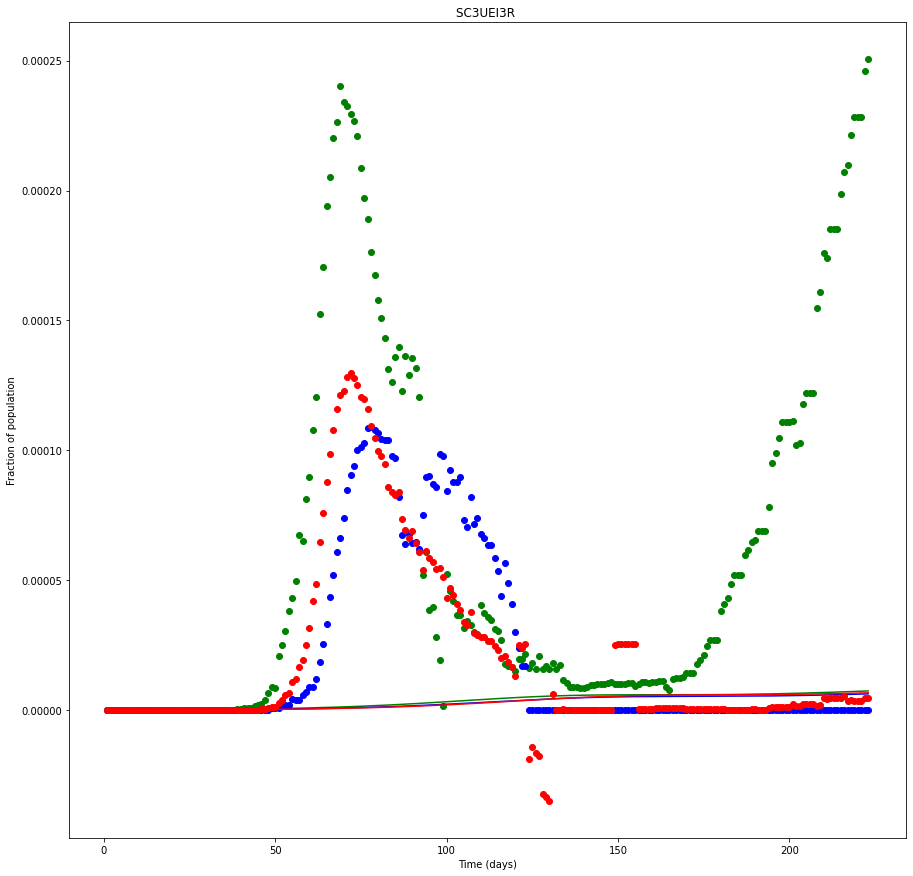

In [182]:
w=interactive(slidefitplot,
         beta_1=FloatSlider(min=0,max=1,step=0.01,value=params['beta_1'],description='beta_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         alpha=FloatSlider(min=0,max=1,step=0.01,value=params['alpha'],description='alpha',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         mu=FloatSlider(min=0,max=0.2,step=0.002,value=params['mu'],description='mu',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         c_0=FloatSlider(min=0,max=1,step=0.01,value=params['c_0'],description='c_0',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_1=FloatSlider(min=0,max=1,step=0.001,value=params['c_1'],description='c_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         c_2=FloatSlider(min=0,max=5000,step=1,value=params['c_2'],description='c_2',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.1f'),
         logI_0=FloatSlider(min=-10,max=0,step=0.01,value=-6,description='log I_0',
                            style=style,layout=slider_layout,continuous_update=False),
         k_u=FloatSlider(min=0,max=1,step=0.001,value=params['k_u'],description='k_u',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         k_1=FloatSlider(min=0,max=1,step=0.001,value=params['k_1'],description='k_1',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),
         k_w=FloatSlider(min=0,max=1,step=0.001,value=params['k_w'],description='k_w',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'),     
         kappa=FloatSlider(min=0,max=1,step=0.001,value=params['kappa'],description='kappa',
                            style=style,layout=slider_layout,continuous_update=False,readout_format='.3f'))
display(w)

In [183]:
params=w.kwargs

print(params)

{'beta_1': 0.2, 'alpha': 0.2, 'mu': 0.16666666666666669, 'c_0': 0.1, 'c_1': 0.016666666666666666, 'c_2': 5000.0, 'logI_0': -6.0, 'k_u': 0.2, 'k_1': 0.011111111111111112, 'k_w': 0.011111111111111112, 'kappa': 0.5}


## Fit SC3EI3R parameters to jhu data based on square_loss

### Fit c_0 , c_1 and c_2 as well as initial value of I_1

In [184]:
SC3EI3R_model.parameters

{beta_1: 0.4,
 beta_2: 0.0,
 beta_3: 0.0,
 alpha: 0.2,
 gamma_1: 0.08125,
 gamma_2: 0.07142857142857142,
 gamma_3: 0.08333333333333331,
 p_1: 0.04375,
 p_2: 0.053571428571428575,
 mu: 0.16666666666666669,
 c_0: 0.1,
 c_1: 0.016666666666666666,
 c_2: 5000.0,
 N: 1.0}

In [206]:
SC3EI3R_model.parameters = {'beta_1': 0.4, 'beta_2': 0.0, 'beta_3': 0.0, 'alpha': 0.2, 'gamma_1': 0.06999999999999999, 'gamma_2': 0.16666666666666669, 'gamma_3': 0.1, 'p_1': 0.030000000000000013, 'p_2': 0.08333333333333333, 'mu': 0.1, 'c_0': 0.1, 'c_1': 0.016666666666666666, 'c_2': 10000.0, 'N': 1.0}

In [231]:
# Initial guess of parameters and initial condition, and bounding constraints
I0 =10**-7
x0_SC3EI3R = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.]
SC3EI3R_model.parameters={'beta_1': 0.41, 'mu': 0.1, 'c_0': 0.1, 'c_1': 0.0166, 'c_2': 10000.0}
cautionparams = list(params.values())[-4:-1]
theta = [0.3,0.0167,10000.] # cautionparams
boxBounds = [(0.3,0.5),(0.01,0.02),(6000.,12000.)]
# set up optimization function with cost and sensitivity (Jacobian)
objSC3EI3R = SquareLoss(theta=theta, ode=SC3EI3R_model, x0=x0_SC3EI3R, t0=t[0], t=t[1::], y=y_jhu[test_country][1::,1:],
                      state_weight=[1.,10.],state_name=['R','D'],
                      target_param=['c_0','c_1','c_2'],target_state=['I_1'])
# perform optimization
res = minimize(fun=objSC3EI3R.costIV,
                jac=objSC3EI3R.sensitivityIV,
                x0=theta+[I0],
                bounds=boxBounds+[(0.00000001,0.000001)],
                #method='BFGS',
                method='SLSQP',
                #options={'disp':True,'maxiter':1000,'eps':0.01,'gtol':0.01})
                #options={'disp':True})
                options={'disp':True,'maxiter':1000,'eps':0.0001,'ftol':0.000001})
print(res)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.765395353588637e-06
            Iterations: 3
            Function evaluations: 6
            Gradient evaluations: 3
     fun: 3.765395353588637e-06
     jac: array([ 4.55663516e-05,  1.49814538e-04, -1.81436808e-09,  3.75330218e+01])
 message: 'Optimization terminated successfully.'
    nfev: 6
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([3.00000000e-01, 1.00000000e-02, 1.00000000e+04, 1.51642853e-07])


{'beta_1': 0.4, 'beta_2': 0.0, 'beta_3': 0.0, 'alpha': 0.2, 'gamma_1': 0.06999999999999999, 'gamma_2': 0.16666666666666669, 'gamma_3': 0.1, 'p_1': 0.030000000000000013, 'p_2': 0.08333333333333333, 'mu': 0.1, 'c_0': 0.1, 'c_1': 0.016666666666666666, 'c_2': 10000.0, 'N': 1.0}
[0.9999996284647709, 0.0, 3.715352290971728e-07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
{'beta_1': 0.4, 'beta_2': 0.0, 'beta_3': 0.0, 'alpha': 0.2, 'gamma_1': 0.06999999999999999, 'gamma_2': 0.16666666666666669, 'gamma_3': 0.1, 'p_1': 0.030000000000000013, 'p_2': 0.08333333333333333, 'mu': 0.1, 'c_0': 0.3, 'c_1': 0.01, 'c_2': 10000.000000035958, 'N': 1.0}
Peak infection (days) 66.96696696696696


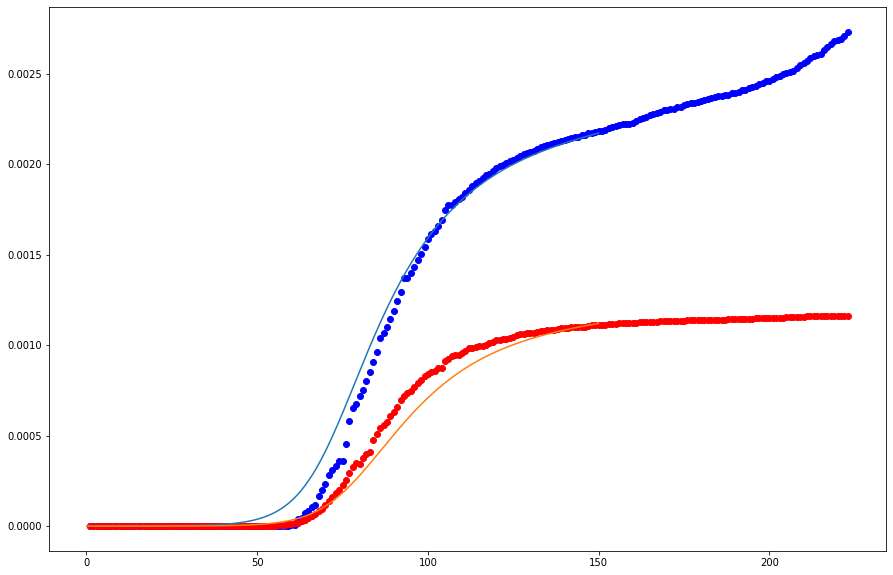

In [229]:
# model with fitted parameters 
print(params)
print(x0_SC3EI3R)
params_fit = params.copy()
params_fit['c_0'] = res.x[0]
params_fit['c_1'] = res.x[1]
params_fit['c_2'] = res.x[2]

SC3EI3R_model.params = params_fit
print(SC3EI3R_model.params)
#ode_fit = common_models.SEI3R({'beta':res.x[0], 'gamma':res.x[1],'alpha':res.x[2]})
#x0_fit = [1-1.27e-6, 1.27e-6, 0]
x0_fit = x0_SC3EI3R.copy()
x0_fit[2] = res.x[3]
t_fit = np.linspace(0, 150, 1000)
#t_fit = t
SC3EI3R_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SCEI3R_model.integrate(t_fit[1::]) # use magic %timeit to time
# sol_fit =SCEI3R_model.integrate(t_fit[0::])
sol_fit = scipy.integrate.odeint(SC3EI3R_model.ode, x0_fit, t_fit[1::])
#
plt.figure(figsize=(15,10))
#plt.plot(t[1::],y_jhu[test_country][1::,0], 'o',color='lightgreen') # infected observations
plt.plot(t[1::],y_jhu[test_country][1::,1], 'bo') # recovered
plt.plot(t[1::],10*y_jhu[test_country][1::,2], 'ro') # died x10
plt.plot(t_fit[1::], sol_fit[::,SC3EI3R_model.recovered]) # R
plt.plot(t_fit[1::], 10*sol_fit[::,SC3EI3R_model.deaths])  # D x10
#plt.ylim([0,0.004])
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

## Testing fitting

### Generate test data based on SCEI3R simulation

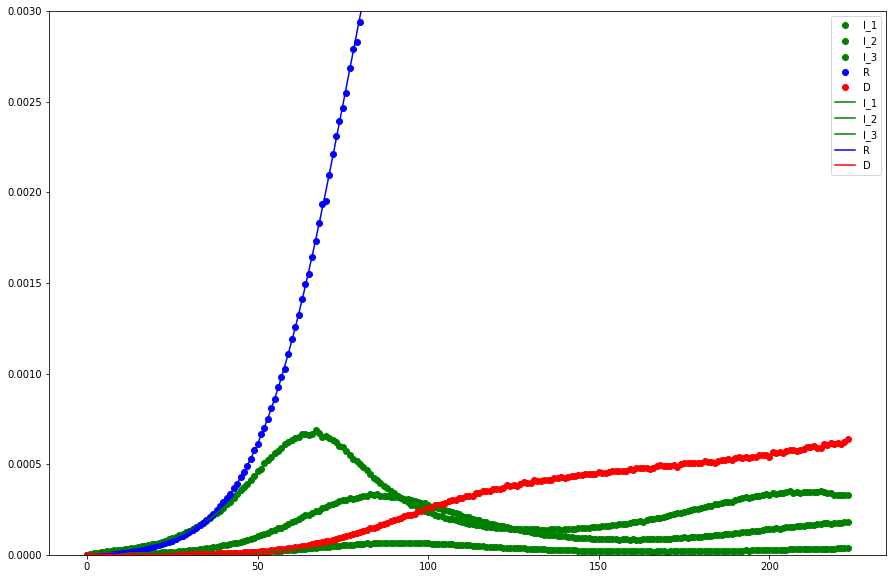

In [240]:
# Add noise
y = solution[:,2:7].copy()
#print('len(y)',len(y),'t',len(t),t[0],t[1],'...',t[-1])
np.random.seed(seed=6)
noise = np.random.normal(0,1.e-2,[len(t),5])
# ynoise = y *(1+noise)
ynoise = y *(1.0 + noise)
ynoise[ynoise<0] = 0
plt.figure(figsize=(15,10))
plt.plot(t,ynoise[:,0], 'go', label='I_1') 
plt.plot(t,ynoise[:,1], 'go', label='I_2') 
plt.plot(t,ynoise[:,2], 'go', label='I_3') 
plt.plot(t,ynoise[:,3], 'bo', label='R') 
plt.plot(t,ynoise[:,4], 'ro', label='D') 
plt.plot(t,y[:,0], 'g', label='I_1') 
plt.plot(t,y[:,1], 'g', label='I_2') 
plt.plot(t,y[:,2], 'g', label='I_3') 
plt.plot(t,y[:,3], 'b', label='R') 
plt.plot(t,y[:,4], 'r', label='D') 
plt.legend()
plt.ylim(0,0.003)
plt.show()

{'beta_1': 0.4, 'beta_2': 0.0, 'beta_3': 0.0, 'alpha': 0.2, 'gamma_1': 0.06999999999999999, 'gamma_2': 0.16666666666666669, 'gamma_3': 0.1, 'p_1': 0.030000000000000013, 'p_2': 0.08333333333333333, 'mu': 0.1, 'c_0': 0.1, 'c_1': 0.016666666666666666, 'c_2': 10000.0, 'N': 1.0}
0.1 0.016666666666666666
[0.99997, 0.0, 3e-05, 0.0, 0.0, 0.0, 0.0, 0.0]
Peak infection (days) 191.0


/usr/local/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


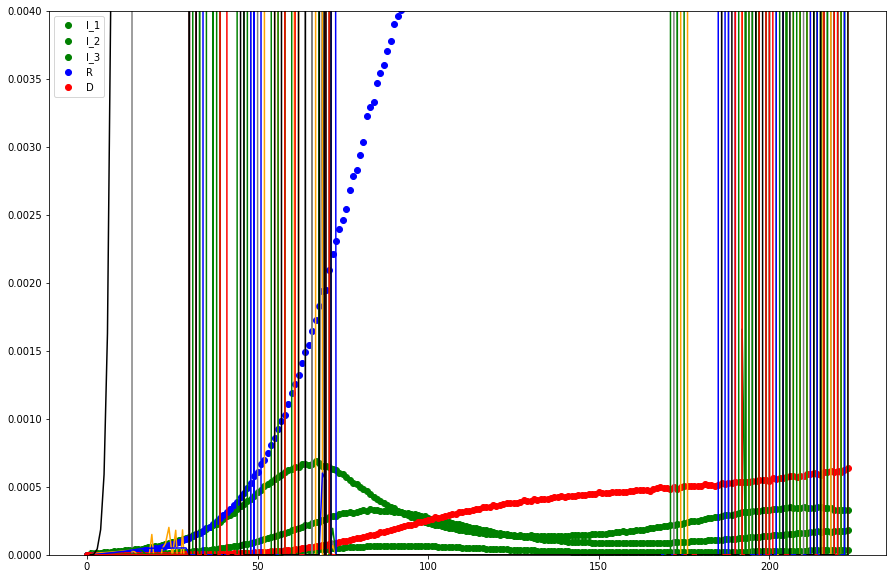

In [241]:
# model with generating parameters 
print(params)
params_fit = params.copy()
print(params_fit['c_0'],params_fit['c_1'])
SCEI3R_model.params = params_fit

x0_fit = x0_SCEI3R.copy()
print(x0_fit)
#t_fit = numpy.linspace(0, 150, 1000)

t_fit = t
SCEI3R_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SCEI3R_model.integrate(t_fit[1::]) # use magic %timeit to time
sol_fit = scipy.integrate.odeint(SCEI3R_model.ode, x0_fit, t_fit[1::])
# print(len(sol_fit[0]))
#
plt.figure(figsize=(15,10))
plt.plot(t,ynoise[:,0], 'go',label='I_1') # infected observations
plt.plot(t,ynoise[:,1], 'go',label='I_2') # infected observations
plt.plot(t,ynoise[:,2], 'go',label='I_3') # infected observations
plt.plot(t,ynoise[:,3], 'bo',label='R') # recoverd
plt.plot(t,ynoise[:,4], 'ro',label='D') # died
plt.gca().set_prop_cycle(color=['grey','orange','green','green','green','blue','red', 'black'])
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0,0.004])
plt.legend()
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

In [235]:
params # use list(...) to convert to list

{'beta_1': 0.4,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333,
 'mu': 0.1,
 'c_0': 0.1,
 'c_1': 0.016666666666666666,
 'c_2': 10000.0,
 'N': 1.0}

### Fit parameters to randomized simulation data based on square_loss

#### Fit c_0 and c_1 only

In [238]:
# Initial guess of parameters, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [value for value in cautionparams]
theta = [0.21,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SCEI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.0,10.0],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'])
# perform optimization
res = minimize(fun=objSCEI3R.cost,
                jac=objSCEI3R.sensitivity,
                x0=theta,
                #bounds=boxBounds,
                method='BFGS',
                options={'disp':True,'maxiter':1000,'eps':0.0001})# ,'ftol':0.01})  #not BFGS
print(res)

InputError: ode not initialized properly or unable to integrate using the initial values provided

#### Fit c_0 and c_1 as well as initial value of E

##### Fit c_0 and c_1 as well as initial value of E with 'SLSQP'
does not work well
note use of special methods IV for initial value fitting of target_state

In [232]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SCEI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEI3R.costIV,
                jac=objSCEI3R.sensitivityIV,
                x0=theta+[0.00005],
                #bounds=boxBounds+[(0.0000001,0.001)],
                method='SLSQP',
                options={'disp':True,'maxiter':1000,'eps':0.01,'ftol':0.01})
print(res)

NameError: name 'ynoise' is not defined

##### Fit c_0 and c_1 as well as initial value of E with BFGS
works well:  no constraints and gtol not ftol

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SCEI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEI3R.costIV,
                jac=objSCEI3R.sensitivityIV,
                x0=theta+[0.00005],
                #bounds=boxBounds+[(0.0000001,0.001)],
                method='BFGS',
                options={'disp':True,'maxiter':1000,'eps':0.01,'gtol':0.01})
print(res)

In [ ]:
# model with fitted parameters 
print(params)
print(x0_SCEI3R)
params_fit = params.copy()
#params_fit['c_0'] = res.x[0]
#params_fit['c_1'] = res.x[1]

SCEI3R_model.params = params_fit
print(SCEI3R_model.params)
#ode_fit = common_models.SEI3R({'beta':res.x[0], 'gamma':res.x[1],'alpha':res.x[2]})
#x0_fit = [1-1.27e-6, 1.27e-6, 0]
x0_fit = x0.copy()
#x0_fit[2] = res.x[2]
#t_fit = numpy.linspace(0, 150, 1000)
t_fit = t
SCEI3R_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SCEI3R_model.integrate(t_fit[1::]) # use magic %timeit to time
# sol_fit =SCEI3R_model.integrate(t_fit[0::])
sol_fit = scipy.integrate.odeint(SCEI3R_model.ode, x0_fit, t_fit[1::])
#
plt.figure(figsize=(15,10))
plt.plot(t,ynoise[:,0], 'go') # infected observations
plt.plot(t,ynoise[:,1], 'go') # infected observations
plt.plot(t,ynoise[:,2], 'go') # infected observations
plt.plot(t,ynoise[:,3], 'bo') # recoverd
plt.plot(t,ynoise[:,4], 'ro') # died
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0,0.004])
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

##### Fit c_0 and c_1 as well as initial value of E using L-BFGS-B
this method does not work well

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SCEI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEI3R.costIV,
                jac=objSCEI3R.sensitivityIV,
                x0=theta+[0.00005],
                bounds=boxBounds+[(0.0000001,0.001)],
                method='L-BFGS-B',
                options={'disp':True,'maxiter':1000,'eps':0.0001,'ftol':0.001})
print(res)

In [ ]:
objSCEI3R.residual()

##### Fit c_0 and c_1 as well as initial value of E with Nelder-Mead
no use of Jacobian and no constraints

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SCEI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEI3R.costIV,
                #jac=objSCEI3R.sensitivityIV,
                x0=theta+[0.00005],
                #bounds=boxBounds+[(0.0000001,0.001)],
                method='Nelder-Mead',
                options={'disp':True,'maxiter':1000}) #,'eps':0.0001,'ftol':0.01}) #not NM
print(res)

In [ ]:
# model with fitted parameters 
print(params)
print(x0_SCEI3R)
params_fit = params.copy()
#params_fit['c_0'] = res.x[0]
#params_fit['c_1'] = res.x[1]

SCEI3R_model.params = params_fit
print(SCEI3R_model.params)
#ode_fit = common_models.SEI3R({'beta':res.x[0], 'gamma':res.x[1],'alpha':res.x[2]})
#x0_fit = [1-1.27e-6, 1.27e-6, 0]
x0_fit = x0_SCEI3R.copy()
#x0_fit[2] = res.x[2]
#t_fit = numpy.linspace(0, 150, 1000)
t_fit = t
SCEI3R_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SCEI3R_model.integrate(t_fit[1::]) # use magic %timeit to time
# sol_fit =SCEI3R_model.integrate(t_fit[0::])
sol_fit = scipy.integrate.odeint(SCEI3R_model.ode, x0_fit, t_fit[1::])
#
plt.figure(figsize=(15,10))
plt.plot(t,ynoise[:,0], 'go') # infected observations
plt.plot(t,ynoise[:,1], 'go') # infected observations
plt.plot(t,ynoise[:,2], 'go') # infected observations
plt.plot(t,ynoise[:,3], 'bo') # recoverd
plt.plot(t,ynoise[:,4], 'ro') # died
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0,0.004])
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

## Fit SC2IR parameters to jhu data based on square_loss

In [ ]:
params=SC2IR_model.parameters
print(params)

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
theta = [0.4,0.11,0.007,0.33,0.228,275.]
boxBounds = [(0.2,0.5),(0.05,0.15),(0.005,0.015),(0.25,0.55),(0.15,0.4),(5.,2000.)]
# setup cost function and Jacobian with target parameters and initial states
objSC2IR = SquareLoss(theta=theta, ode=SC2IR_model, x0=x0, t0=t[0], t=t[1::], y=y_jhu[test_country][1::,1:3],
                      state_weight=[0.2,1.],state_name=['R','D'],
                      target_param=['beta','gamma','mu','c_0','c_1','c_2'],
                      target_state=['I'])
# perform optimization
res = minimize(fun=objSC2IR.costIV,
                jac=objSC2IR.sensitivityIV,
                x0=theta+[0.000000001],
                bounds=boxBounds+[(0.0000000001,0.000001)],
                # method='L-BFGS-B',
                # method='Nelder-Mead',
                #options={'disp':True,'maxiter':1000,'eps':0.01,'gtol':0.01})
                options={'disp':True,'maxiter':1000,'eps':0.000001,'ftol':0.000000001})
print(res)

In [ ]:
# model with fitted parameters 
startparams = SC2IR_model.parameters.copy()  # save starting parameters (not fit)
print(params)
print(x0)
params_fit = params.copy()
params_fit['beta'] = res.x[0]
params_fit['gamma'] = res.x[1]
params_fit['mu'] = res.x[2]
params_fit['c_0'] = res.x[3]
params_fit['c_1'] = res.x[4]
params_fit['c_2'] = res.x[5]

SC2IR_model.params = params_fit
print(SC2IR_model.params)
x0_fit = x0.copy()
x0_fit[1] = res.x[6]
t_fit = t
SC2IR_model.initial_values = (x0_fit, t_fit[0])
sol_fit = scipy.integrate.odeint(SC2IR_model.ode, x0_fit, t_fit[1::])
#
plt.figure(figsize=(15,10))
plt.semilogy()
plt.ylim([0.000001,1])
plt.plot(t,y_jhu[test_country][:,1], 'bo',label='R')  # recovered
plt.semilogy()
plt.ylim([0.000001,1])
plt.plot(t,y_jhu[test_country][:,2], 'ro',label='D')  # died
plt.semilogy()
plt.ylim([0.000001,1])

plt.gca().set_prop_cycle(color=['grey','green','blue','red', 'black'])
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0.000001,1])
plt.legend(('R','D','S','I','R','D','S_c','I_c'))
plt.semilogy()
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,1])
print('Peak infection (days)', t_fit[peak_i])
SC2IR_model.parameters = startparams

## Fit SC3EI3R parameters to jhu data based on square_loss

### Fit c_0 and c_1 only

In [ ]:
# Initial guess of parameters, and bounding constraints
cautionparams = list(params.values())[-4:-1]
theta = [value for value in cautionparams]
print(theta)
theta = [0.3,0.08,2500.]
boxBounds = [(0.2,0.8),(0.05,0.15),(100.,10000.)]
objSC3EI3R = SquareLoss(theta=theta, ode=SC3EI3R_model, x0=x0_SC3EI3R, t0=t[0], t=t[1::], y=y_jhu[test_country][1::,1:3],
                      state_weight=[1.,1.],state_name=['R','D'],
                      target_param=['c_0','c_1','c_2'])
# perform optimization
res = minimize(fun=objSC3EI3R.cost,
                #jac=objSC3EI3R.sensitivity,
                x0=theta,
                #bounds=boxBounds,
                method='L-BFGS-B',
                # method='Nelder-Mead',
                options={'disp':True,'maxiter':1000,'eps':0.00001})# ,'ftol':0.01})  #not BFGS
print(res)

### Fit c_0 and c_1 as well as initial value of E

#### Fit c_0 and c_1 as well as initial value of E with 'SLSQP'
does not work well
note use of special methods IV for initial value fitting of target_state

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-3]
theta = [value for value in cautionparams]
theta = [0.21,0.08,2500.]
objSC3EI3R = SquareLoss(theta=theta, ode=SC3EI3R_model, x0=x0_SC3EI3R, t0=t[0], t=t[1::], y=y_jhu[test_country][1::,1:3],
                      state_weight=[1.,1.],state_name=['R','D'],
                      target_param=['c_0','c_1','c_2'],target_state=['I_1'])
# perform optimization
res = minimize(fun=objSC3EI3R.costIV,
                jac=objSC3EI3R.sensitivityIV,
                x0=theta+[0.00005],
                bounds=boxBounds+[(0.0000001,0.001)],
                # method='BFGS',
                method='L-BFGS-B',
                options={'disp':True,'maxiter':1000,'eps':0.01,'gtol':0.01})
print(res)

#### Fit c_0 and c_1 as well as initial value of E with BFGS
works well:  no constraints and gtol not ftol

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SC3EI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEI3R.costIV,
                jac=objSCEI3R.sensitivityIV,
                x0=theta+[0.00005],
                #bounds=boxBounds+[(0.0000001,0.001)],
                method='BFGS',
                options={'disp':True,'maxiter':1000,'eps':0.01,'gtol':0.01})
print(res)

In [ ]:
# model with fitted parameters 
print(params)
print(x0_SC3EI3R)
params_fit = params.copy()
#params_fit['c_0'] = res.x[0]
#params_fit['c_1'] = res.x[1]

SC3EI3R_model.params = params_fit
print(SC3EI3R_model.params)
#ode_fit = common_models.SEI3R({'beta':res.x[0], 'gamma':res.x[1],'alpha':res.x[2]})
#x0_fit = [1-1.27e-6, 1.27e-6, 0]
x0_fit = x0_SC3EI3R.copy()
#x0_fit[2] = res.x[2]
#t_fit = numpy.linspace(0, 150, 1000)
t_fit = t
SC3EI3R_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SCEI3R_model.integrate(t_fit[1::]) # use magic %timeit to time
# sol_fit =SCEI3R_model.integrate(t_fit[0::])
sol_fit = scipy.integrate.odeint(SC3EI3R_model.ode, x0_fit, t_fit[1::])
#
plt.figure(figsize=(15,10))
plt.plot(t,ynoise[:,0], 'o',color='lightgreen') # infected observations
plt.plot(t,ynoise[:,1], 'o',color='green') # infected observations
plt.plot(t,ynoise[:,2], 'o',color='darkgreen') # infected observations
plt.plot(t,ynoise[:,3], 'bo') # recoverd
plt.plot(t,ynoise[:,4], 'ro') # died
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0,0.004])
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

#### Fit c_0 and c_1 as well as initial value of E using L-BFGS-B
this method does not work well

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SC3EI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEI3R.costIV,
                jac=objSCEI3R.sensitivityIV,
                x0=theta+[0.00005],
                bounds=boxBounds+[(0.0000001,0.001)],
                method='L-BFGS-B',
                options={'disp':True,'maxiter':1000,'eps':0.0001,'ftol':0.001})
print(res)

In [ ]:
objSCEI3R.residual()

#### Fit c_0 and c_1 as well as initial value of E with Nelder-Mead
no use of Jacobian and no constraints

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
cautionparams = list(params.values())[-4:-2]
theta = [0.25,0.08]
boxBounds = [(0.2,0.4),(0.05,0.15)]
objSCEI3R = SquareLoss(theta=theta, ode=SCEI3R_model, x0=x0_SC3EI3R, t0=t[0], t=t[1::], y=ynoise[1::,:],
                      state_weight=[1.,1.,1.,1.,1.],state_name=['I_1','I_2','I_3','R','D'],
                      target_param=['c_0','c_1'],target_state=['E'])
# perform optimization
res = minimize(fun=objSCEI3R.costIV,
                #jac=objSCEI3R.sensitivityIV,
                x0=theta+[0.00005],
                #bounds=boxBounds+[(0.0000001,0.001)],
                method='Nelder-Mead',
                options={'disp':True,'maxiter':1000}) #,'eps':0.0001,'ftol':0.01}) #not NM
print(res)

In [ ]:
# model with fitted parameters 
print(params)
print(x0_SC3EI3R)
params_fit = params.copy()
params_fit['c_0'] = res.x[0]
params_fit['c_1'] = res.x[1]

SC3EI3R_model.params = params_fit
print(SC3EI3R_model.params)
x0_fit = x0_SC3EI3R.copy()
#x0_fit[2] = res.x[2]
#t_fit = numpy.linspace(0, 150, 1000)
t_fit = t
SC3EI3R_model.initial_values = (x0_fit, t_fit[0])
# %timeit sol_fit =SC3EI3R_model.integrate(t_fit[1::]) # use magic %timeit to time
# sol_fit =SC3EI3R_model.integrate(t_fit[0::])
sol_fit = scipy.integrate.odeint(SC3EI3R_model.ode, x0_fit, t_fit[1::])
#
plt.figure(figsize=(15,10))
plt.plot(t,y_jhu[:,0], 'bo') # recoverd
plt.plot(t,y_jhu[:,1], 'ro') # died
plt.plot(t_fit[1::], sol_fit)
plt.ylim([0,0.004])
#plt.show(())
#ode_fit.plot()

peak_i = np.argmax(sol_fit[:,2])
print('Peak infection (days)', t_fit[peak_i])

### Information on method options

In [ ]:
scipy.optimize.show_options(solver='minimize', method='SLSQP', disp=True)
print(' ')
scipy.optimize.show_options(solver='minimize', method='L-BFGS-B', disp=True)

## Plot using full control

In [ ]:
def plotmodel(solns,t,scale='linear',species='no_susc',plottitle= '',label='',
              newplot = True,models=['SEI3R','SCEI3R','SC3EI3R']):
    """
    plot solns over 
    times t interpreted as models indicated in models parameter
    scale: alternative 'linear' or 'log'
    species alternatives 'all', 'confirmed', 'deaths', 'daily confirmed', 'daily deaths'
    plottitle : title for plot
    label : label for curve when called as part of multicurve plot
    newplot : whether to open new plot True/False
    models : list of models to include, default all three of those possible
    """
   
    nmodels = len(models)
    if len(solns) != len(models):
        print("Error: number of models must match number of solutions")
        return None
    nm = 0
    
    if newplot == True:
        plt.figure(figsize=(nmodels*8,6))
 
    for nm in range(nmodels):
        soln = solns[nm]
        if models[nm] == 'SEI3R':   #SEI3R
            plt.subplot(1,nmodels,nm+1)
            if scale == 'log': #Plot on log scale
                plt.semilogy()
                plt.ylim([1,10000])
            elif species != 'daily confirmed': # Plot on normal linear scale
                #plt.ylim([0,10000])
                pass
            if species == 'no_susc':
                plt.plot(tvec,soln[:,1:5],label=label)
                plt.legend(("E","I1","I2","I3"))
            elif species == 'confirmed' or species == 'daily confirmed':
                suma = np.sum(soln[:,2:7],axis=1)
                # print('length=',len(suma))
                if species == 'daily confirmed':
                    sumd = np.zeros(len(suma))
                    for i in range(1,len(suma)):
                        sumd[i] = suma[i]-suma[i-1]
                    #plt.ylim([0,1000])
                    plt.plot(tvec,sumd,label=label)
                else:
                    #plt.ylim([0,200000])
                     plt.plot(t,suma,label=label)                   
            elif species == 'all':
                plt.plot(tvec,soln,label=label)
                plt.legend(("S","E","I1","I2","I3","R","D"))
            plt.xlabel("Time (days)")
            plt.ylabel("Portion of population N")
            plt.title('SEI3R %s' % plottitle)

        elif models[nm] == 'SCEI3R':   #SCEI3R
            #Plot
            plt.subplot(1,nmodels,nm+1)
            if scale == 'log': #Plot on log scale
                plt.semilogy()
                plt.ylim([1,10000])
            elif species != 'daily confirmed': # Plot on normal linear scale
                #plt.ylim([0,10000])
                pass
            if species == 'no_susc':
                plt.plot(t,soln[:,1:5],label=label)
                plt.legend(("E","I1","I2","I3"))
            elif species == 'confirmed' or species == 'daily confirmed':
                suma = np.sum(soln[:,2:7],axis=1)
                # print('length=',len(suma))
                if species == 'daily confirmed':
                    sumd = np.zeros(len(suma))
                    for i in range(1,len(suma)):
                        sumd[i] = suma[i]-suma[i-1]
                    #plt.ylim([0,1000])
                    plt.plot(t,sumd,label=label)
                else:
                    #plt.ylim([0,200000])
                    plt.plot(t,suma,label=label)
            elif species == 'all':
                plt.plot(t,soln,label=label)
                plt.legend(("S","E","I1","I2","I3","R","D","Sc"))
            plt.xlabel("Time (days)")
            plt.ylabel("Portion of population N")
            plt.title('SCEI3R %s' % plottitle)
        elif models[nm] == 'SC3EI3R':   #SC3EI3R
            plt.subplot(1,nmodels,nm+1)
            if scale == 'log': #Plot on log scale
                plt.semilogy()
                plt.ylim([1,10000])
            elif species != 'daily confirmed': # Plot on normal linear scale
                #plt.ylim([0,10000])
                pass
            if species == 'no_susc':
                plt.plot(t,sol[:,1:5])
                plt.legend(("E","I1","I2","I3"))
            elif species == 'confirmed' or species == 'daily confirmed':
                suma = np.sum(soln[:,2:7],axis=1) + soln[:,9]
                if species == 'daily confirmed':
                    sumd = np.zeros(len(suma))
                    for i in range(1,len(suma)):
                        sumd[i] = suma[i]-suma[i-1]
                    # plt.ylim([0,1000])
                    plt.plot(t,sumd,label=label)
                else:
                    # plt.ylim([0,200000])
                    plt.plot(t,suma,label=label)
            elif species == 'all':
                plt.plot(t,soln,label=label)
                plt.legend(("S","E","I1","I2","I3","R","D","Sc","Ec","I1c"))
            plt.xlabel("Time (days)")
            plt.ylabel("Portion of population N")
            plt.title('SC3EI3R %s' % plottitle)
    return True

In [ ]:
plotmodel([sol_fit],t_fit[1:],scale='linear',species='no_susc',plottitle= 'test',label='',
              newplot = True,models=['SCEI3R'])